In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e18/sample_submission.csv
/kaggle/input/playground-series-s3e18/train.csv
/kaggle/input/playground-series-s3e18/test.csv


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc
import time
import math

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import seaborn as sns
from category_encoders import OrdinalEncoder, CountEncoder, CatBoostEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, LabelEncoder # OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA, NMF
from umap import UMAP
from sklearn.decomposition import FastICA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
import shap

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', '.*DataFrame is highly fragmented*')

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [98]:
pd.set_option('display.max_columns', 1000)

## Data

In [99]:
filepath = '/kaggle/input/playground-series-s3e18'
generated_filepath = '/kaggle/input/ec-mixed-class'

train_dataset = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
test_dataset = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
new_col = list(set(train_dataset.columns) - set(test_dataset.columns))
for each in new_col : 
    test_dataset[each] = 0
original = pd.concat([train_dataset , test_dataset], ignore_index = True)


# Define columns
# num_cols = test_dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
# cat_cols = test_dataset.select_dtypes(include=['object']).columns.tolist()
target_cols = [
    'EC1', 
    'EC2'
]
num_cols = [
    'BertzCT',
    'Chi1',
    'Chi1n',
    'Chi1v',
    'Chi2n',
    'Chi2v',
    'Chi3v',
    'Chi4n',
    'EState_VSA1',
    'EState_VSA2',
    'ExactMolWt',
    'FpDensityMorgan1',
    'FpDensityMorgan2',
    'FpDensityMorgan3',
    'HallKierAlpha',
    'HeavyAtomMolWt',
    'Kappa3',
    'MaxAbsEStateIndex',
    'MinEStateIndex',
    'NumHeteroatoms',
    'PEOE_VSA10',
    'PEOE_VSA14',
    'PEOE_VSA6',
    'PEOE_VSA7',
    'PEOE_VSA8',
    'SMR_VSA10',
    'SMR_VSA5',
    'SlogP_VSA3',
    'VSA_EState9',
    'fr_COO',
    'fr_COO2',
    ]
binary_cols = [
    'EC3',
    'EC4',
    'EC5',
    'EC6',
]

train_dataset['is_generated'] = 1
test_dataset['is_generated'] = 1
original['is_generated'] = 0

print(f"train shape :{train_dataset.shape}, ", f"test shape :{test_dataset.shape}")
print(f"original shape :{original.shape}")

train shape :(14838, 38),  test shape :(9893, 38)
original shape :(24731, 38)


In [100]:
train_dataset.shape

(14838, 38)

In [101]:
test_dataset.head(2)

BertzCT       Chi1     Chi1n     Chi1v     Chi2n     Chi2v  \
id                                                                      
14838   344.632371   7.283603  4.473966  5.834958  3.412257  4.651530   
14839  1432.410201  10.663869  7.079026  8.065215  5.297097  5.297097   

          Chi3v     Chi4n  EState_VSA1  EState_VSA2  ExactMolWt  \
id                                                                
14838  2.096558  1.116433    49.458581     0.000000  204.079707   
14839  3.924155  2.569694     0.000000    29.783175  315.210331   

       FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  HallKierAlpha  \
id                                                                           
14838          1.384615          1.923077          2.307692          -0.24   
14839          0.571429          0.857143          1.159286          -1.81   

       HeavyAtomMolWt     Kappa3  MaxAbsEStateIndex  MinEStateIndex  \
id                                                                    
14838         192.197   3.247123          10.248693       -4.734642   
14839         280.263  10.070000          11.917927       -0.303333   

       NumHeteroatoms  PEOE_VSA10  PEOE_VSA14  PEOE_VSA6  PEOE_VSA7  \
id                                                                    
14838               7   18.311899   13.512441   0.000000   0.000000   
14839               4    0.000000    0.000000  34.947374  98.323987   

       PEOE_VSA8  SMR_VSA10   SMR_VSA5  SlogP_VSA3  VSA_EState9  fr_COO  \
id                                                                        
14838   0.000000  26.809272  24.539800    4.794537    47.304082       1   
14839   9.606882   0.000000  53.378235    0.000000    43.166667       0   

       fr_COO2  EC1  EC6  EC4  EC5  EC3  EC2  is_generated  
id                                                          
14838        1    0    0    0    0    0    0             1  
14839        0    0    0    0    0    0    0             1

In [102]:
def get_counts(df): 
    column_list = list(df.columns)
    describe_data = pd.DataFrame(df.describe()).T
    unique_counts = pd.DataFrame(df[column_list].nunique()).rename(columns={0 : 'unique_counts'})
    null_counts = pd.DataFrame(df[column_list].isna().sum()).rename(columns={0 : 'null_counts'})
    combined_stats = pd.concat([describe_data, unique_counts, null_counts], axis=1)
    return combined_stats.T , describe_data , unique_counts , null_counts

In [103]:
combined_stats , describe_data , unique_counts , null_counts = get_counts(train_dataset)

In [104]:
combined_stats

BertzCT          Chi1         Chi1n         Chi1v  \
count          14838.000000  14838.000000  14838.000000  14838.000000   
mean             515.153604      9.135189      5.854307      6.738497   
std              542.456370      6.819989      4.647064      5.866444   
min                0.000000      0.000000      0.000000      0.000000   
25%              149.103601      4.680739      2.844556      2.932842   
50%              290.987941      6.485270      4.052701      4.392859   
75%              652.652585     11.170477      7.486791      8.527859   
max             4069.959780     69.551167     50.174588     53.431954   
unique_counts   2368.000000   1259.000000   3157.000000   3306.000000   
null_counts        0.000000      0.000000      0.000000      0.000000   

                      Chi2n         Chi2v         Chi3v         Chi4n  \
count          14838.000000  14838.000000  14838.000000  14838.000000   
mean               4.432570      5.253221      3.418749      1.773472   
std                3.760516      4.925065      3.436208      1.865898   
min                0.000000      0.000000      0.000000      0.000000   
25%                1.949719      2.034468      1.160763      0.503897   
50%                2.970427      3.242775      1.948613      1.073261   
75%                5.788793      6.609350      4.502070      2.534281   
max               32.195368     34.579313     22.880836     16.072810   
unique_counts   3634.000000   3725.000000   3448.000000   2930.000000   
null_counts        0.000000      0.000000      0.000000      0.000000   

                EState_VSA1   EState_VSA2    ExactMolWt  FpDensityMorgan1  \
count          14838.000000  14838.000000  14838.000000      14838.000000   
mean              29.202823     10.435316    292.623087          1.236774   
std               31.728679     13.651843    225.384140          5.491284   
min                0.000000      0.000000      1.007276       -666.000000   
25%                5.969305      0.000000    148.037173          1.045455   
50%               17.353601      6.420822    206.042653          1.250000   
75%               44.876559     12.841643    343.090331          1.500000   
max              363.705954     99.936429   2237.318490          3.000000   
unique_counts    719.000000    445.000000   1666.000000        556.000000   
null_counts        0.000000      0.000000      0.000000          0.000000   

               FpDensityMorgan2  FpDensityMorgan3  HallKierAlpha  \
count              14838.000000      14838.000000   14838.000000   
mean                   1.812070          2.255470      -1.207776   
std                    5.495565          5.501200       0.935314   
min                 -666.000000       -666.000000      -7.730000   
25%                    1.690909          2.100000      -1.660000   
50%                    1.865152          2.358491      -1.100000   
75%                    2.062153          2.500000      -0.570000   
max                    3.200000          3.400000       0.820000   
unique_counts        650.000000        654.000000     388.000000   
null_counts            0.000000          0.000000       0.000000   

               HeavyAtomMolWt        Kappa3  MaxAbsEStateIndex  \
count            14838.000000  14838.000000       14838.000000   
mean               274.950211      5.874372          10.556443   
std                212.678755     45.730226           1.559331   
min                  0.000000   -104.040000           0.000000   
25%                136.109000      1.784008           9.926190   
50%                194.276500      3.261011          10.421334   
75%                326.002000      5.848400          11.539743   
max               2035.133000   1512.242231          15.630251   
unique_counts      860.000000   2245.000000        2356.000000   
null_counts          0.000000      0.000000           0.000000   

               MinEStateIndex  NumHeteroatoms    PEOE_VSA10    PEOE_VSA14  \
count      

# EDA

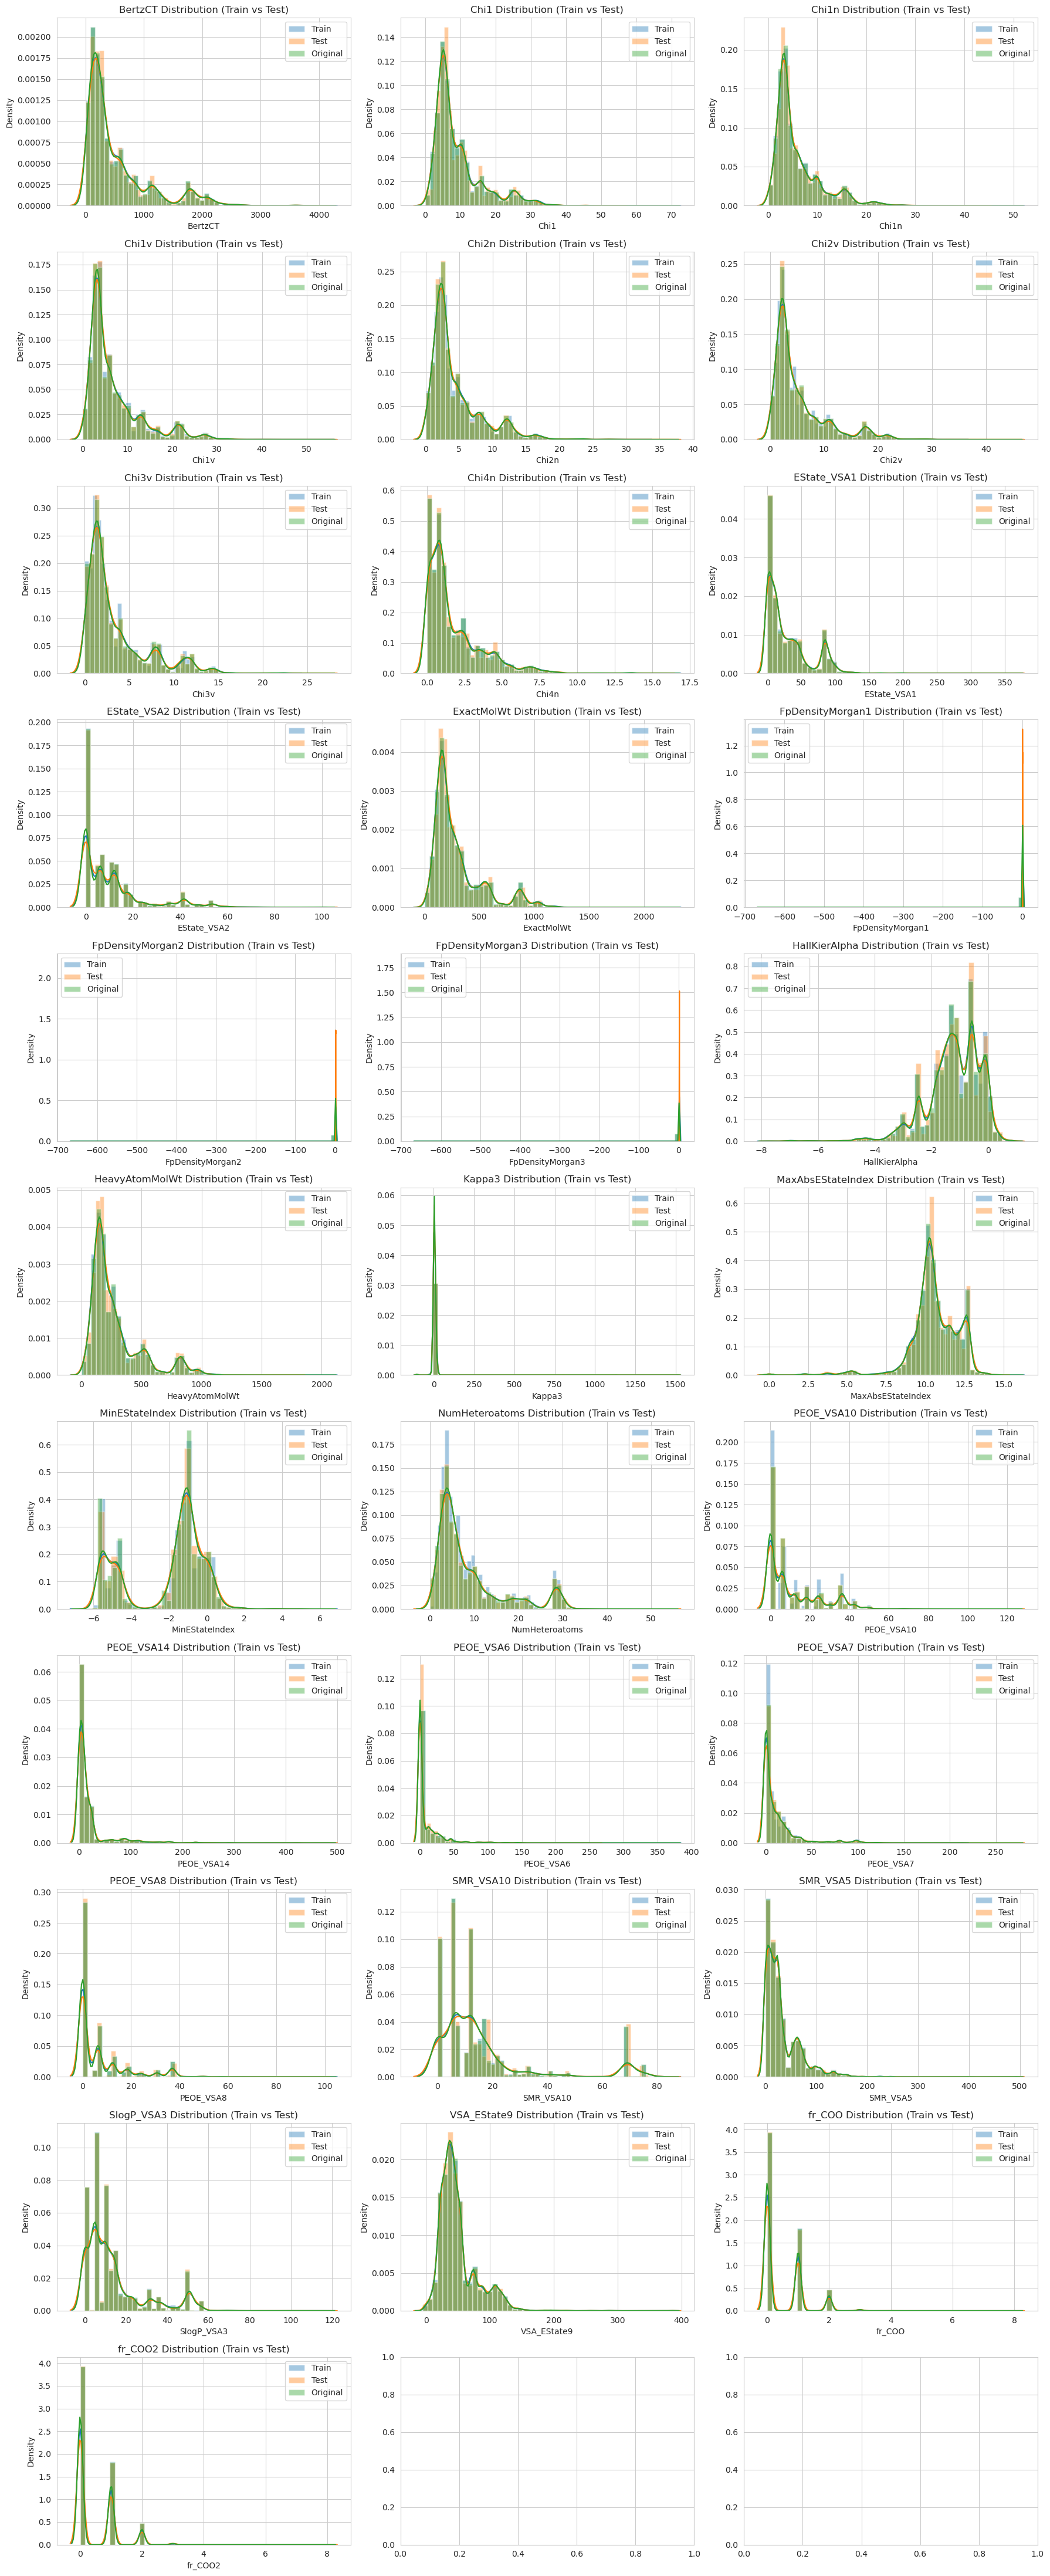

In [105]:
def plot_histograms(train_dataset, test_dataset, original, target_col, n_cols=3):
    n_rows = (len(train_dataset.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(train_dataset.columns.tolist()):
        if var_name != 'is_generated':
            ax = axes[i]
            sns.distplot(train_dataset[var_name], kde=True, ax=ax, label='Train')
            if var_name != target_col:
                sns.distplot(test_dataset[var_name], kde=True, ax=ax, label='Test')
            sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
            ax.set_title(f'{var_name} Distribution (Train vs Test)')
            ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(train_dataset[num_cols], test_dataset[num_cols], original[num_cols], target_cols[0], n_cols=3)


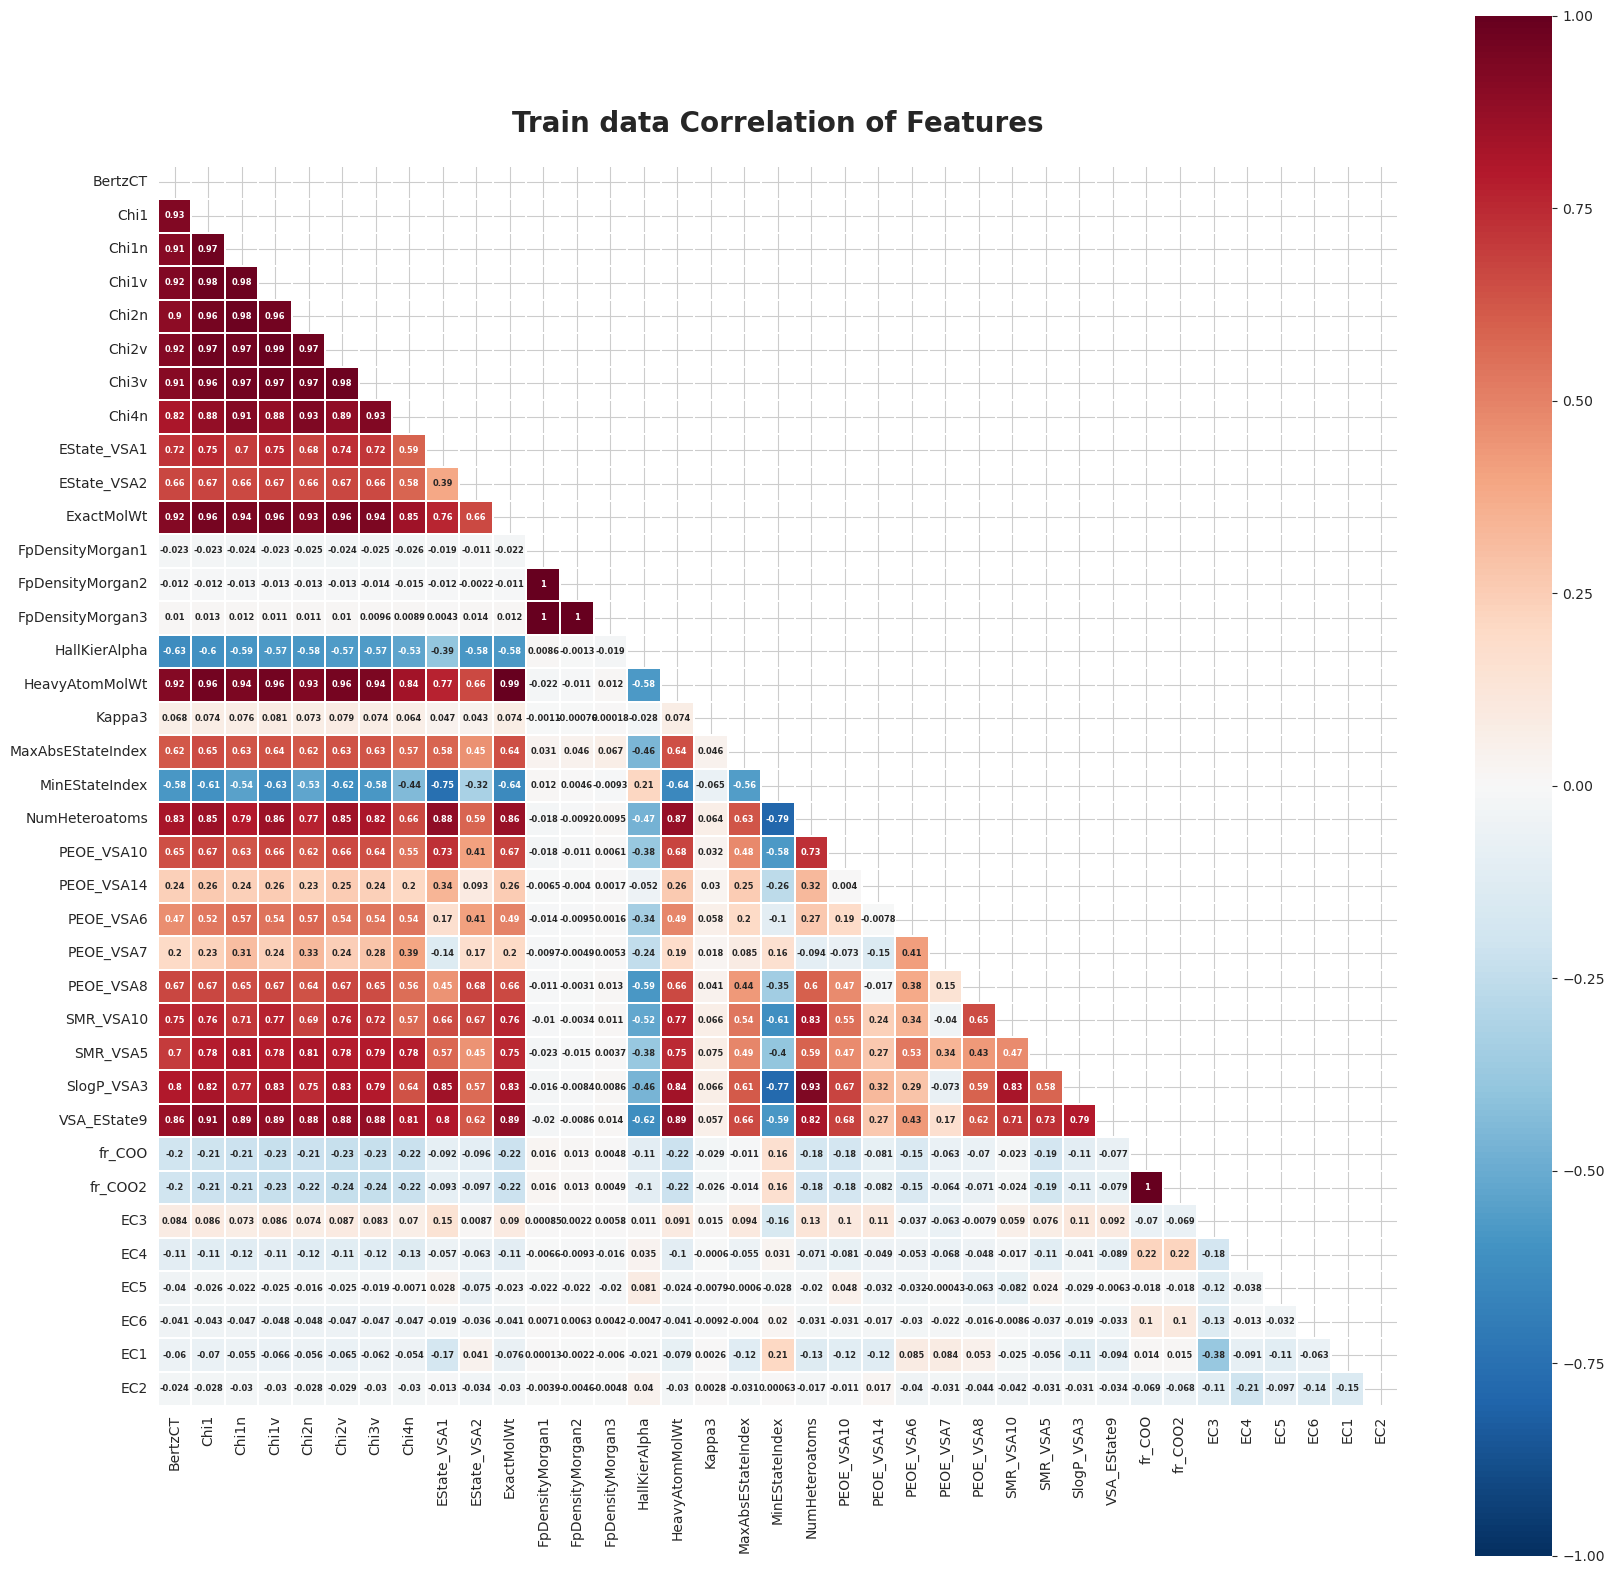

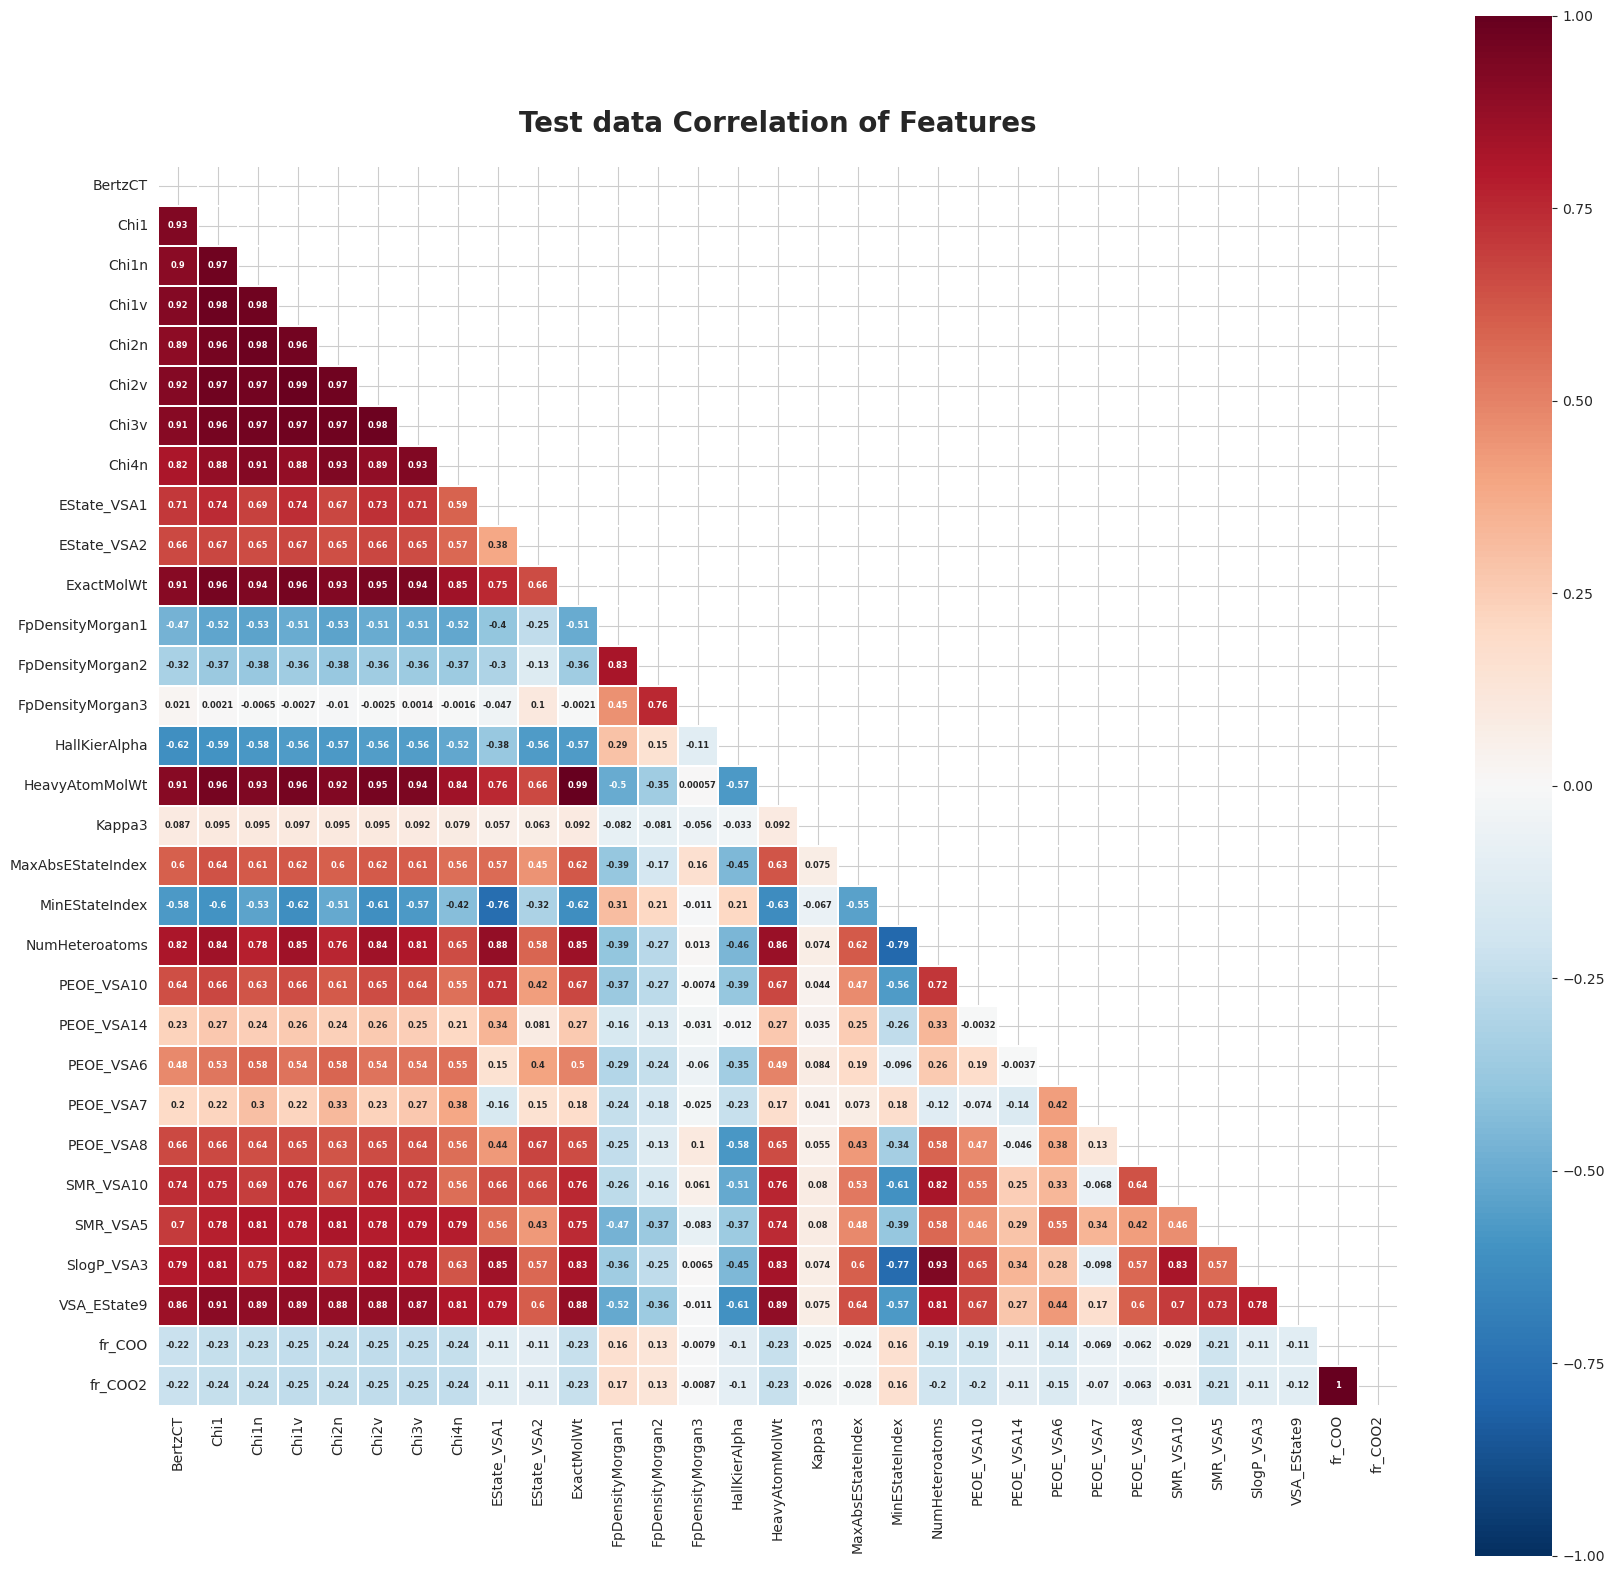

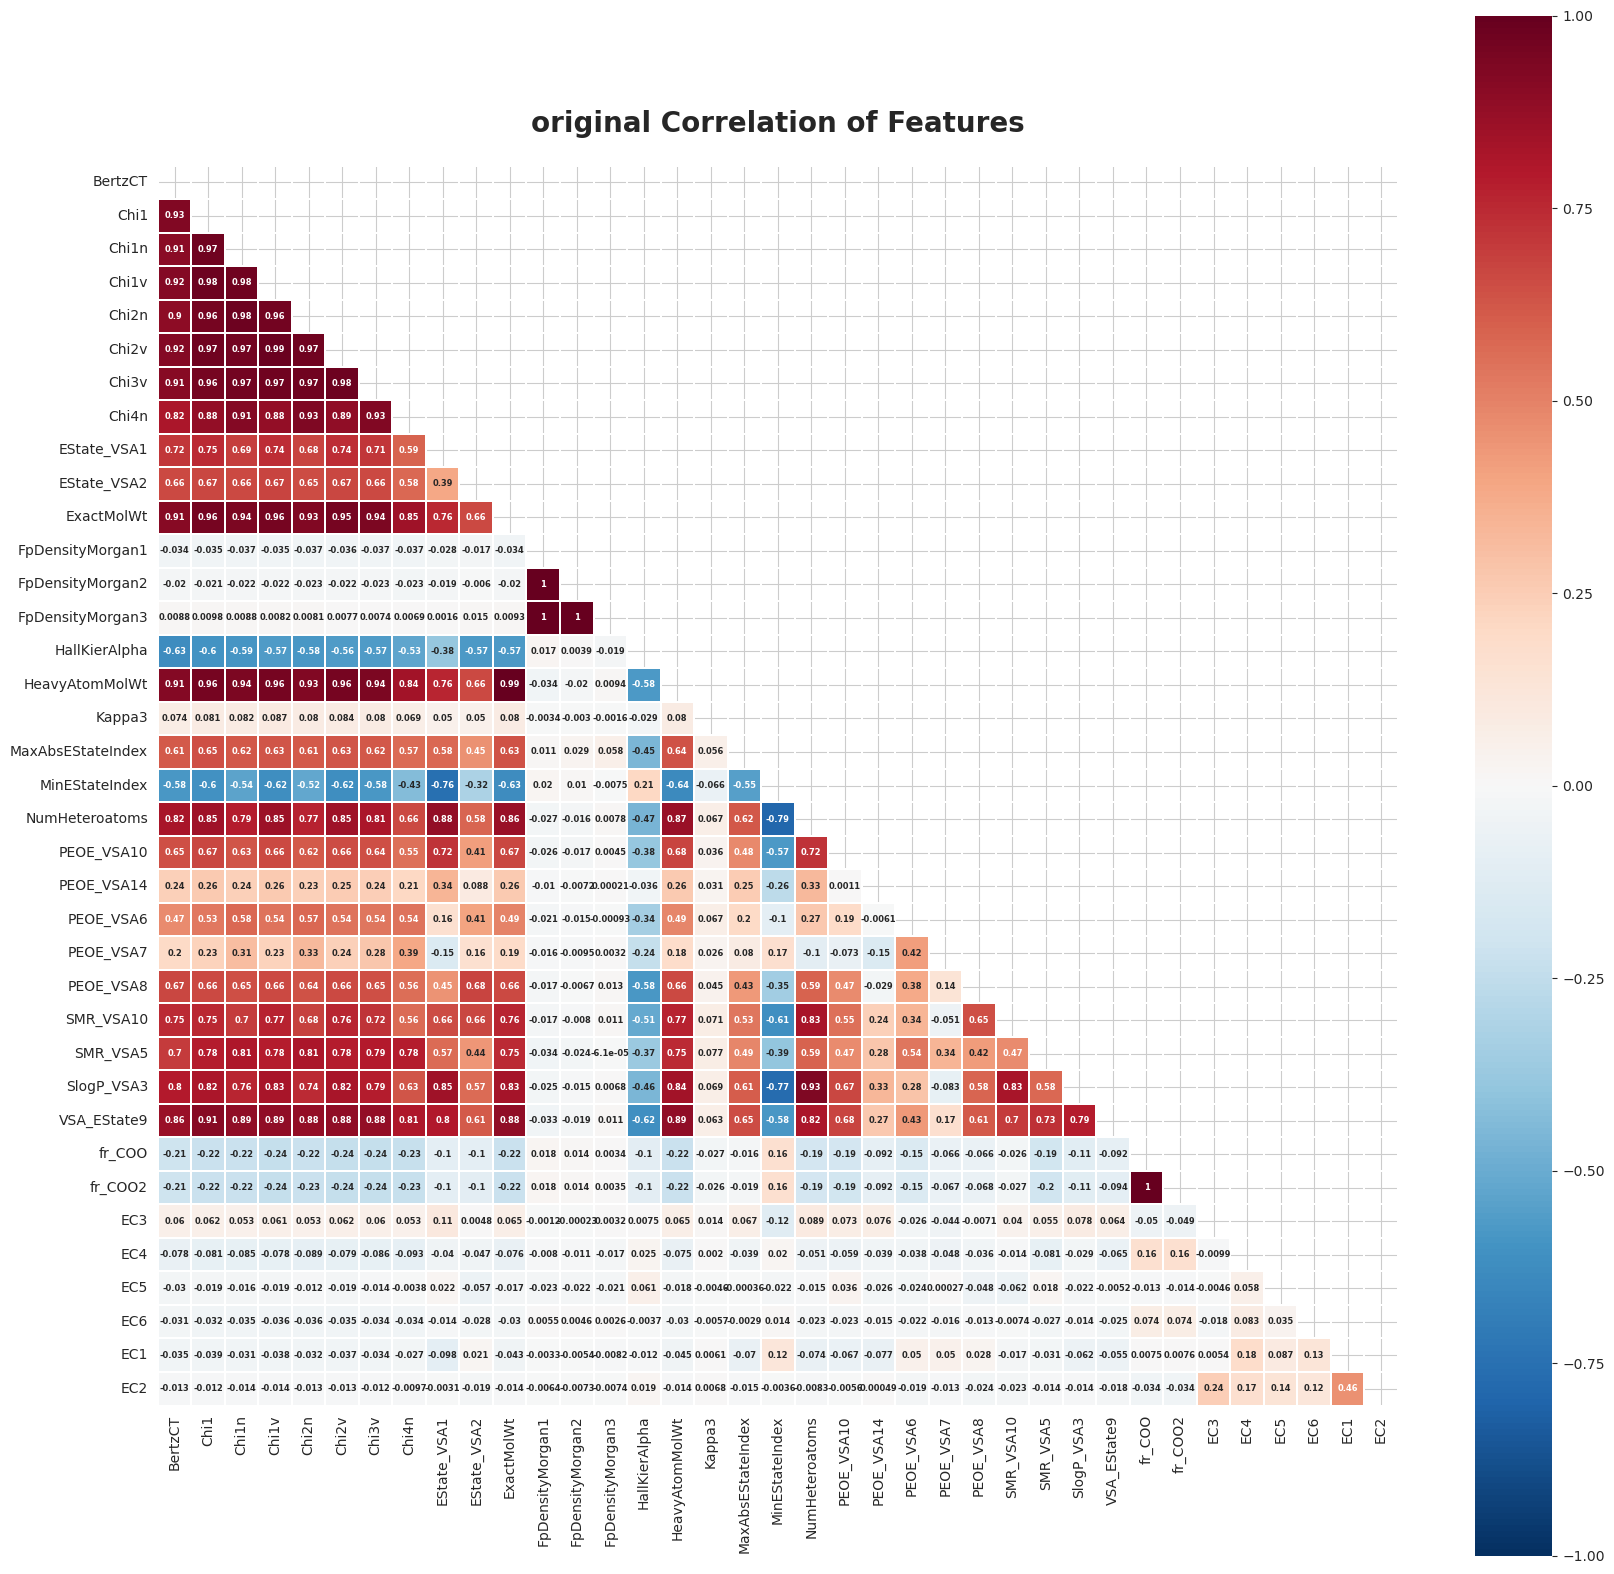

In [106]:
def plot_heatmap(df, title, figsize=(20, 20), fontsize=6):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=figsize)

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": fontsize, "weight": "bold"},
                mask=mask)

plot_heatmap(train_dataset[num_cols+binary_cols+target_cols], title='Train data')
plot_heatmap(test_dataset[num_cols], title='Test data')
plot_heatmap(original[num_cols+binary_cols+target_cols], title='original')

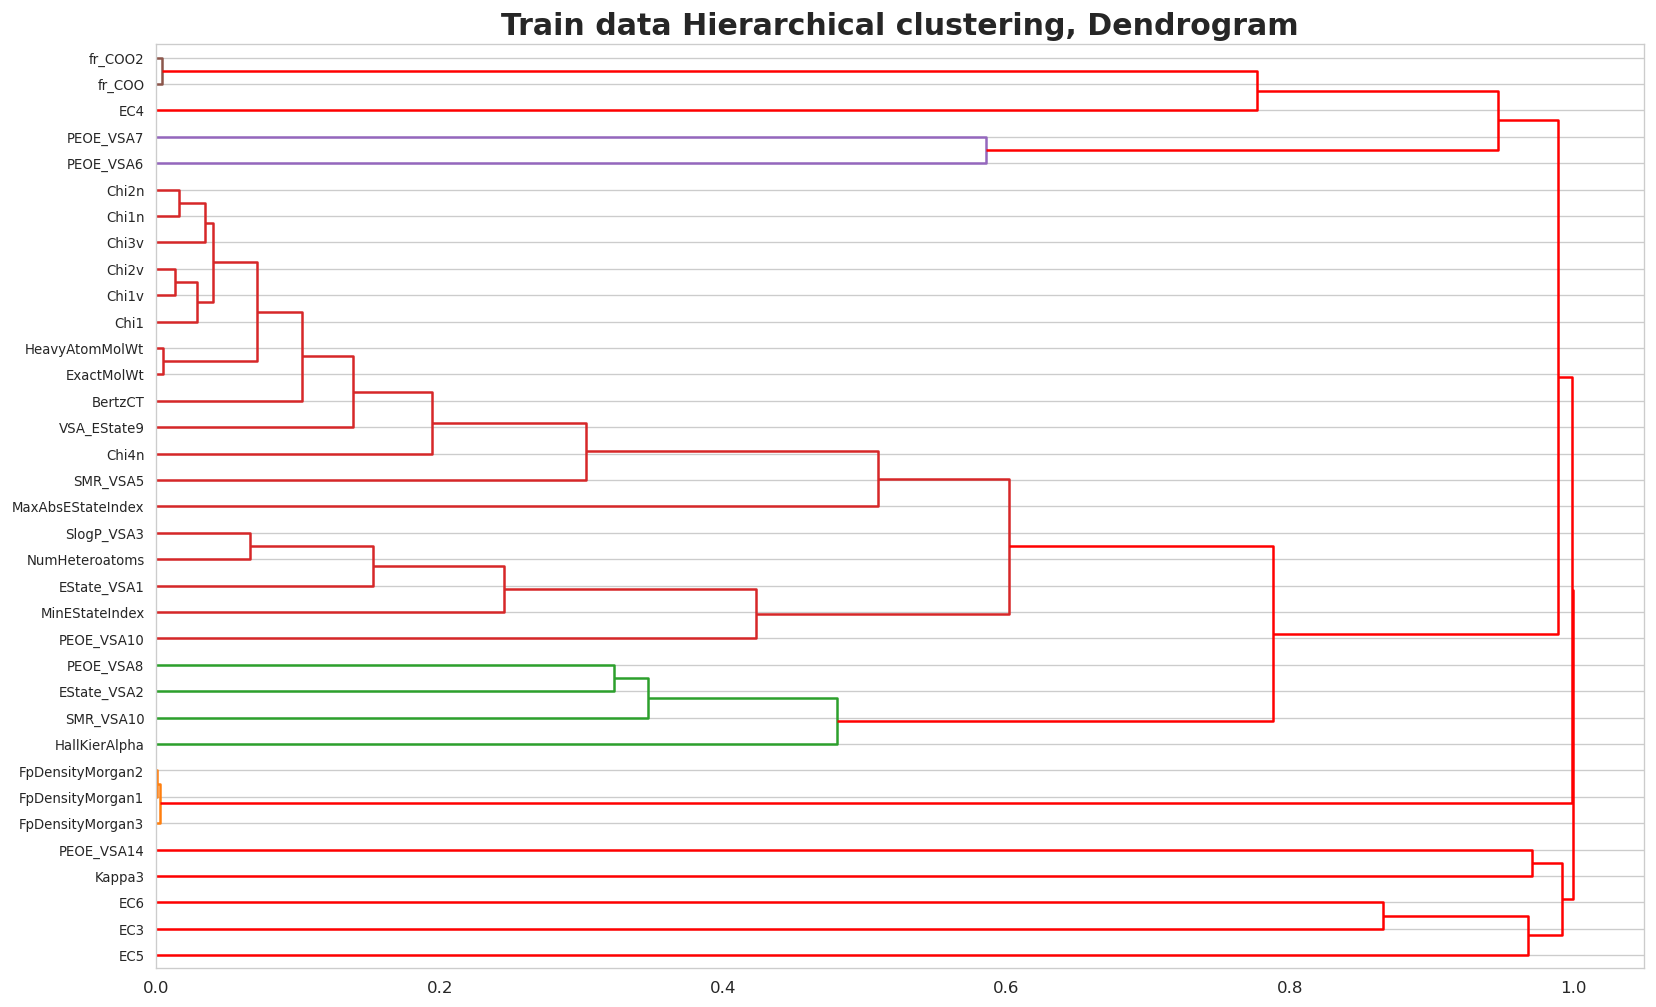

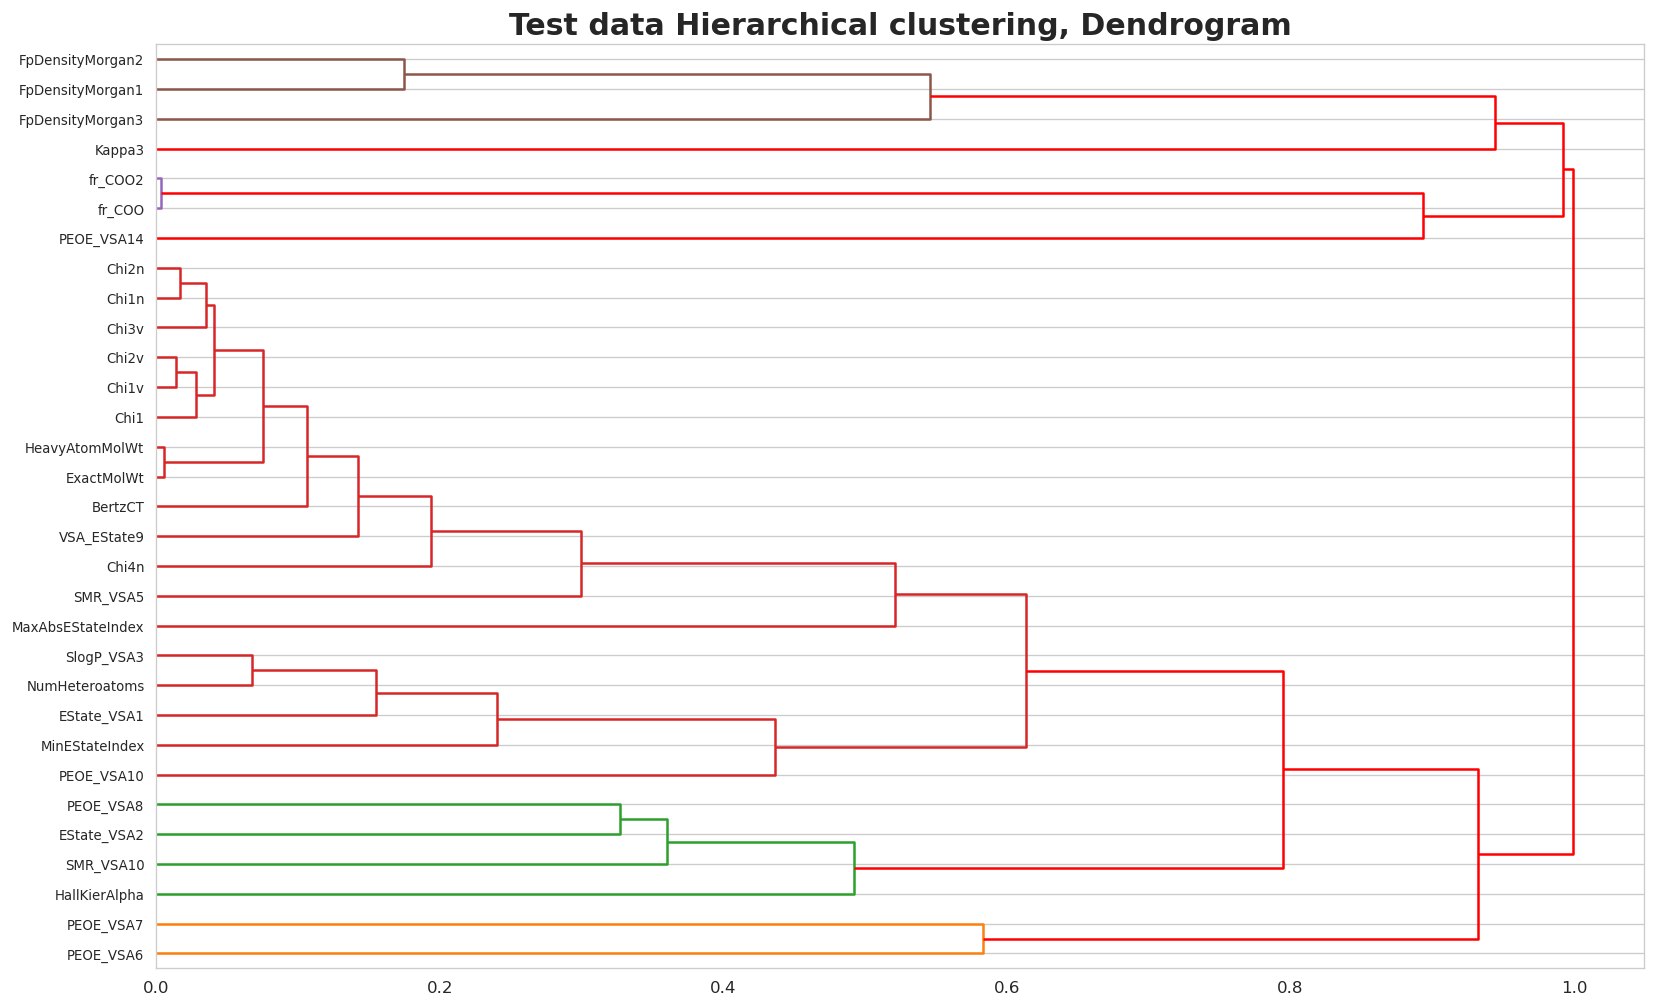

In [107]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def hierarchical_clustering(data, title):
    fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=120)
    correlations = data.corr()
    converted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(converted_corr), 'complete')
    
    dn = dendrogram(Z, labels=data.columns, ax=ax, above_threshold_color='#ff0000', orientation='right')
    hierarchy.set_link_color_palette(None)
    plt.grid(axis='x')
    plt.title(f'{title} Hierarchical clustering, Dendrogram', fontsize=18, fontweight='bold')
    plt.show()

hierarchical_clustering(train_dataset[num_cols+binary_cols], title='Train data')
hierarchical_clustering(test_dataset[num_cols], title='Test data')

In [108]:
def _get_percentage_values(new_df , col_name) : 
#     print(new_df.columns)
    train_count = pd.DataFrame(new_df[col_name].value_counts()).reset_index()
    train_count.columns = ['Values' , 'Count']
    train_count['% Presence'] = (train_count['Count']/train_count['Count'].sum())*100
    return train_count
    
def get_percentage_values(train , test , org , col_name) : 
    train_df = _get_percentage_values(train , col_name)
    train_df['class'] = 'Train'
    test_df = _get_percentage_values(test , col_name)
    test_df['class'] = 'Test'
    org_df = _get_percentage_values(org , col_name)
    org_df['class'] = 'Overall'
    df = pd.concat([train_df, test_df, org_df])
    df = df.set_index(['Values','class']).stack().unstack([1,2])
    return df

In [109]:
test_dataset.columns

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2', 'EC1', 'EC6', 'EC4', 'EC5', 'EC3', 'EC2',
       'is_generated'],
      dtype='object')

In [110]:
data  = get_percentage_values(train_dataset , test_dataset , original , 'EC1')
data

class    Train               Test             Overall           
         Count % Presence   Count % Presence    Count % Presence
Values                                                          
0       4930.0  33.225502  9893.0      100.0  14823.0  59.936921
1       9908.0  66.774498     NaN        NaN   9908.0  40.063079

In [111]:
data  = get_percentage_values(train_dataset , test_dataset , original , 'EC2')
data

class     Train               Test             Overall           
          Count % Presence   Count % Presence    Count % Presence
Values                                                           
0        2983.0  20.103788  9893.0      100.0  12876.0  52.064211
1       11855.0  79.896212     NaN        NaN  11855.0  47.935789

In [112]:
data  = get_percentage_values(train_dataset , test_dataset , original , 'fr_COO')
data

class    Train               Test             Overall           
         Count % Presence   Count % Presence    Count % Presence
Values                                                          
0       9325.0  62.845397  6246.0  63.135550  15571.0  62.961465
1       4332.0  29.195309  2837.0  28.676842   7169.0  28.987910
2       1107.0   7.460574   737.0   7.449712   1844.0   7.456229
3         64.0   0.431325    66.0   0.667138    130.0   0.525656
4          2.0   0.013479     4.0   0.040433      6.0   0.024261
5          3.0   0.020218     NaN        NaN      3.0   0.012131
6          1.0   0.006739     NaN        NaN      1.0   0.004044
7          NaN        NaN     1.0   0.010108      1.0   0.004044
8          4.0   0.026958     2.0   0.020216      6.0   0.024261

In [113]:
data  = get_percentage_values(train_dataset , test_dataset , original , 'fr_COO2')
data

class    Train               Test             Overall           
         Count % Presence   Count % Presence    Count % Presence
Values                                                          
0       9311.0  62.751045  6234.0  63.014253  15545.0  62.856334
1       4345.0  29.282922  2846.0  28.767816   7191.0  29.076867
2       1108.0   7.467314   740.0   7.480036   1848.0   7.472403
3         64.0   0.431325    66.0   0.667138    130.0   0.525656
4          2.0   0.013479     4.0   0.040433      6.0   0.024261
5          3.0   0.020218     NaN        NaN      3.0   0.012131
6          1.0   0.006739     NaN        NaN      1.0   0.004044
7          NaN        NaN     1.0   0.010108      1.0   0.004044
8          4.0   0.026958     2.0   0.020216      6.0   0.024261

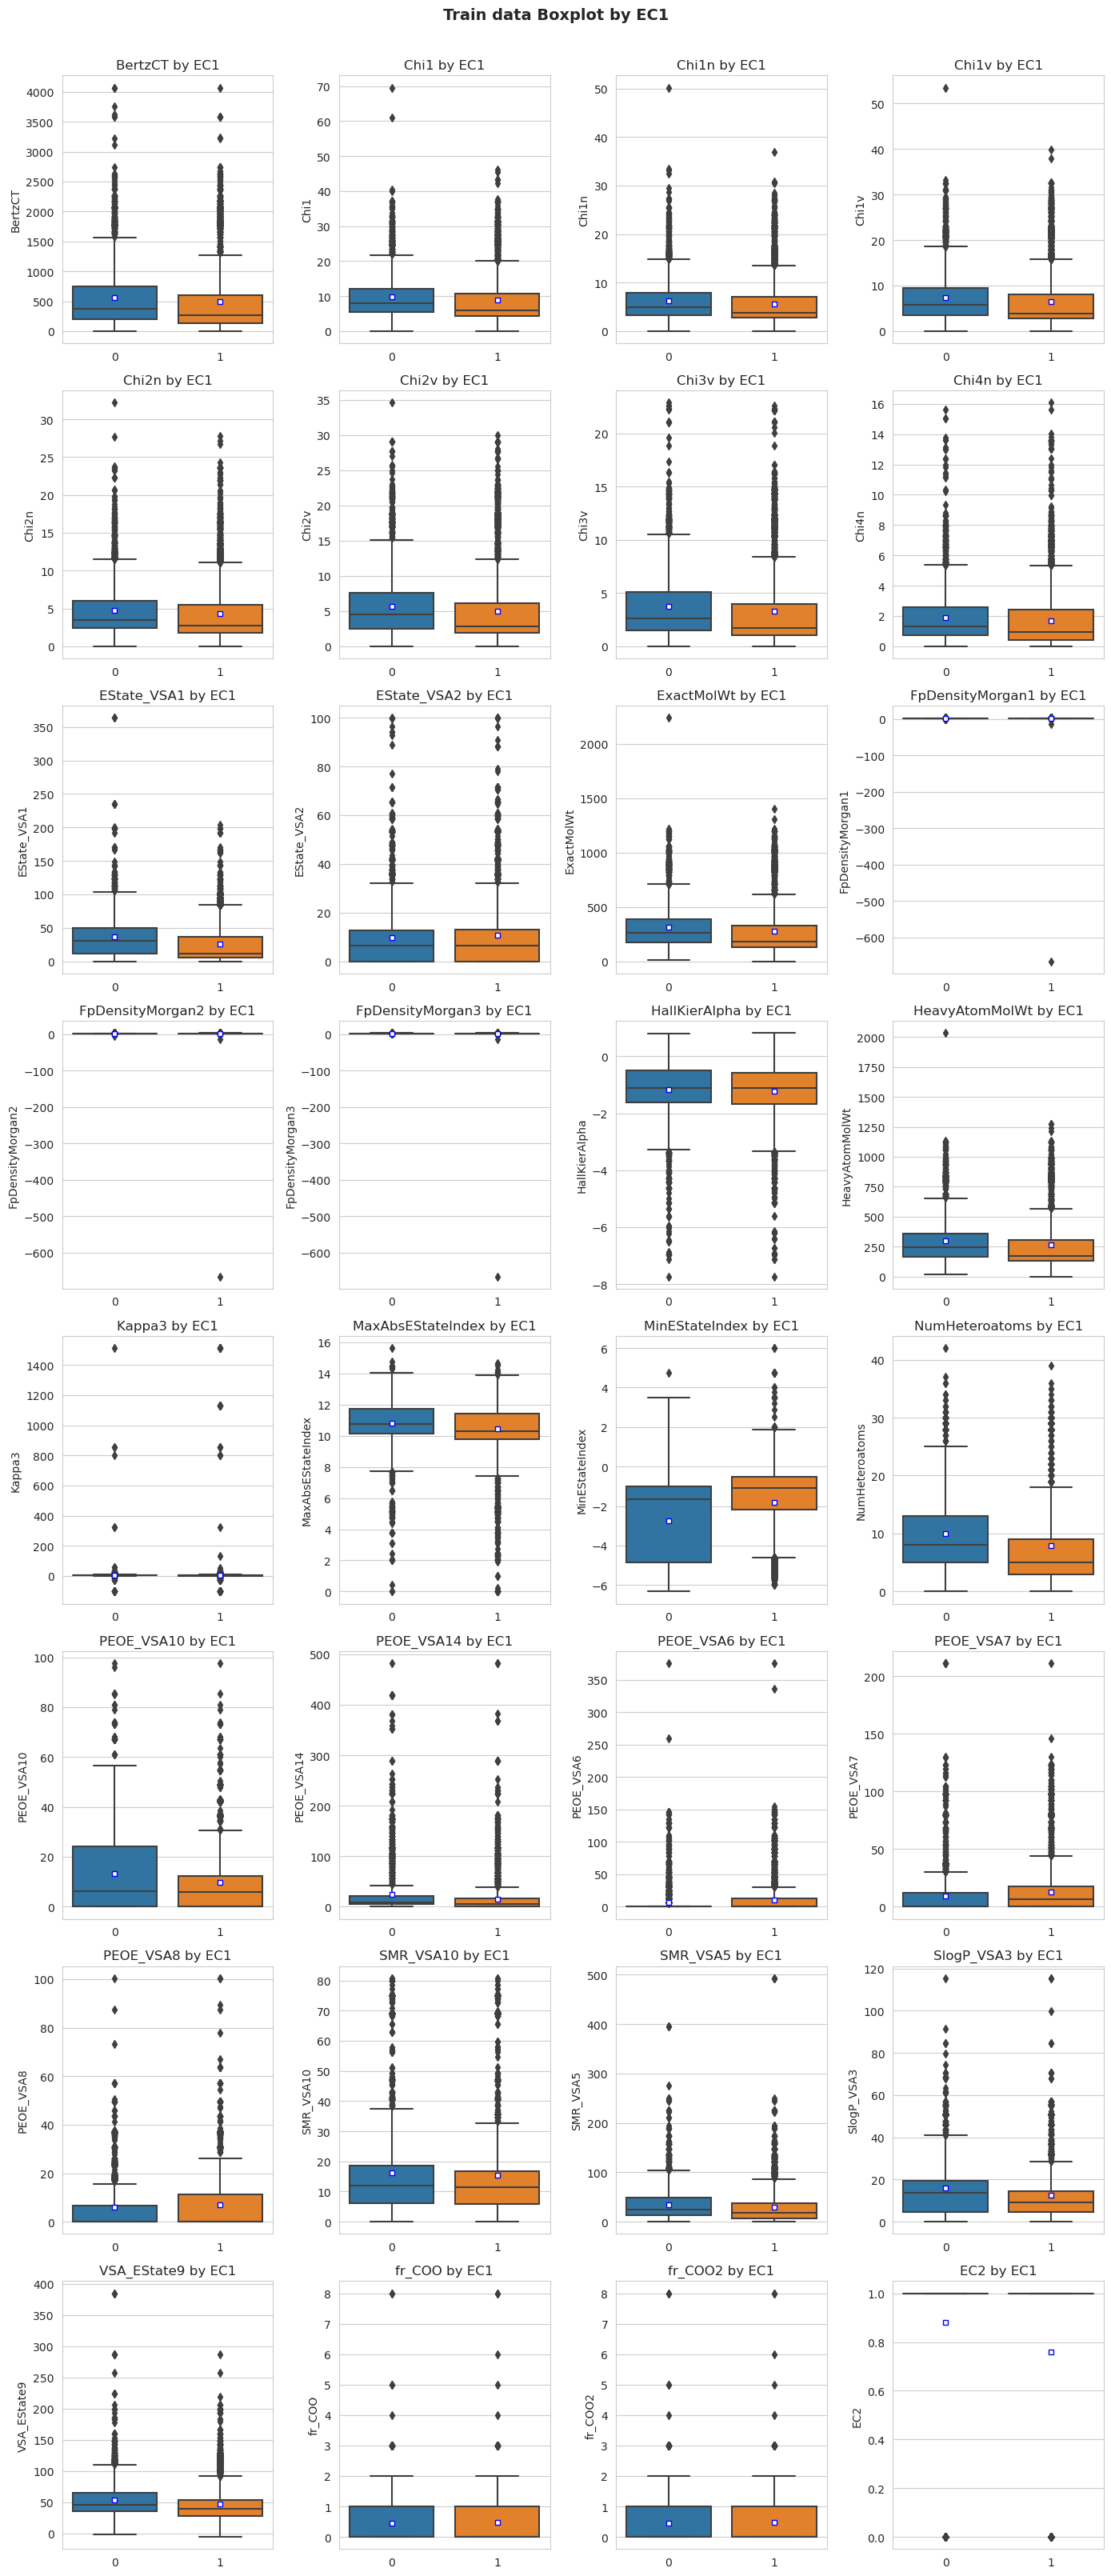

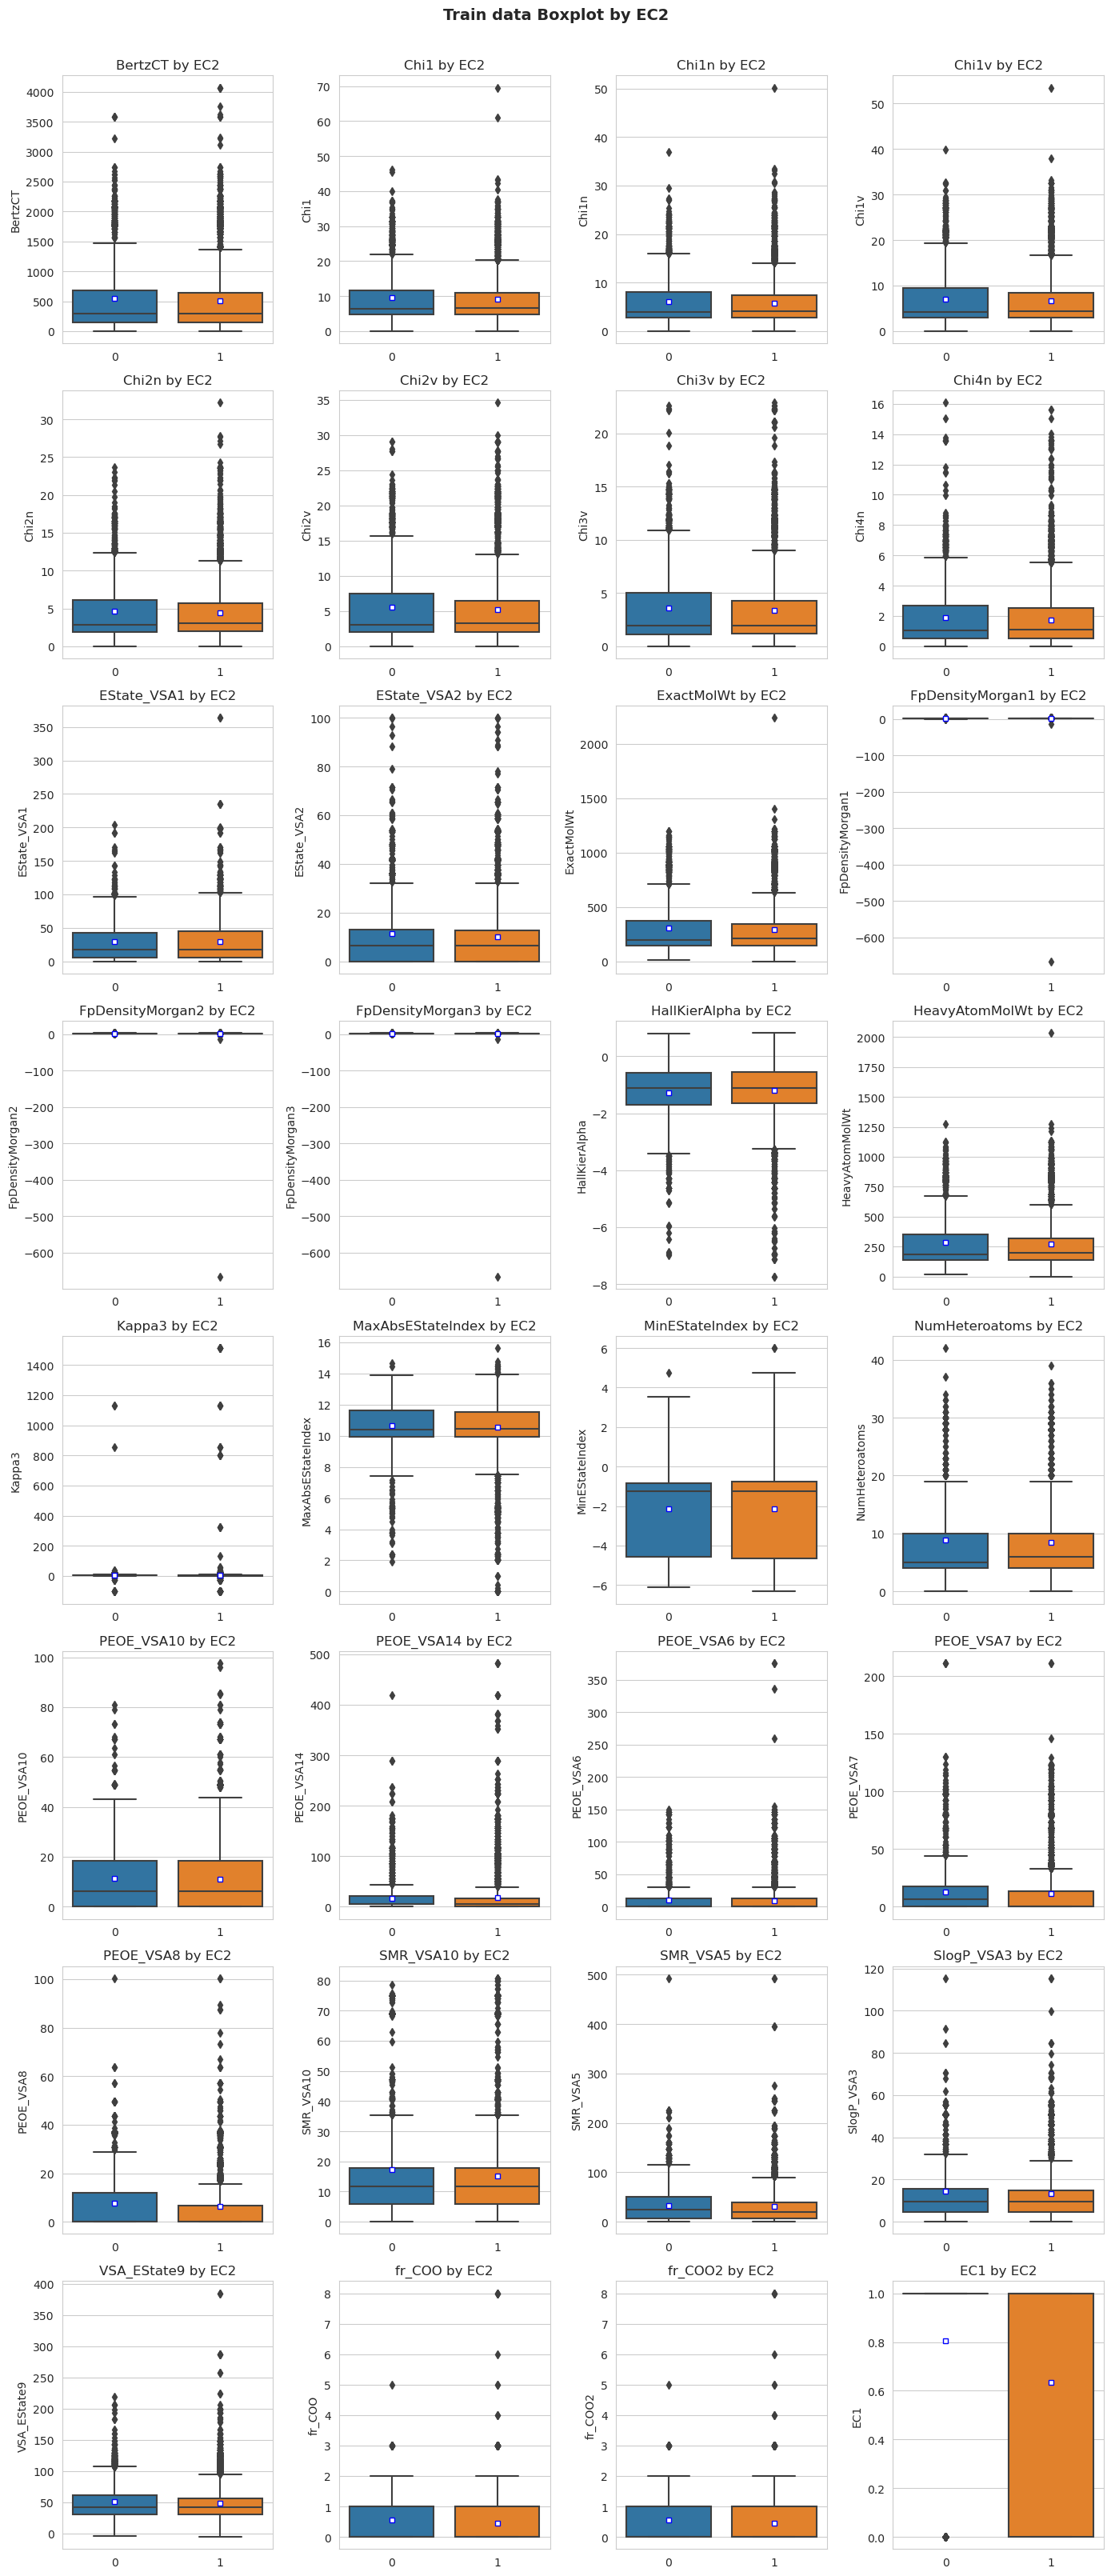

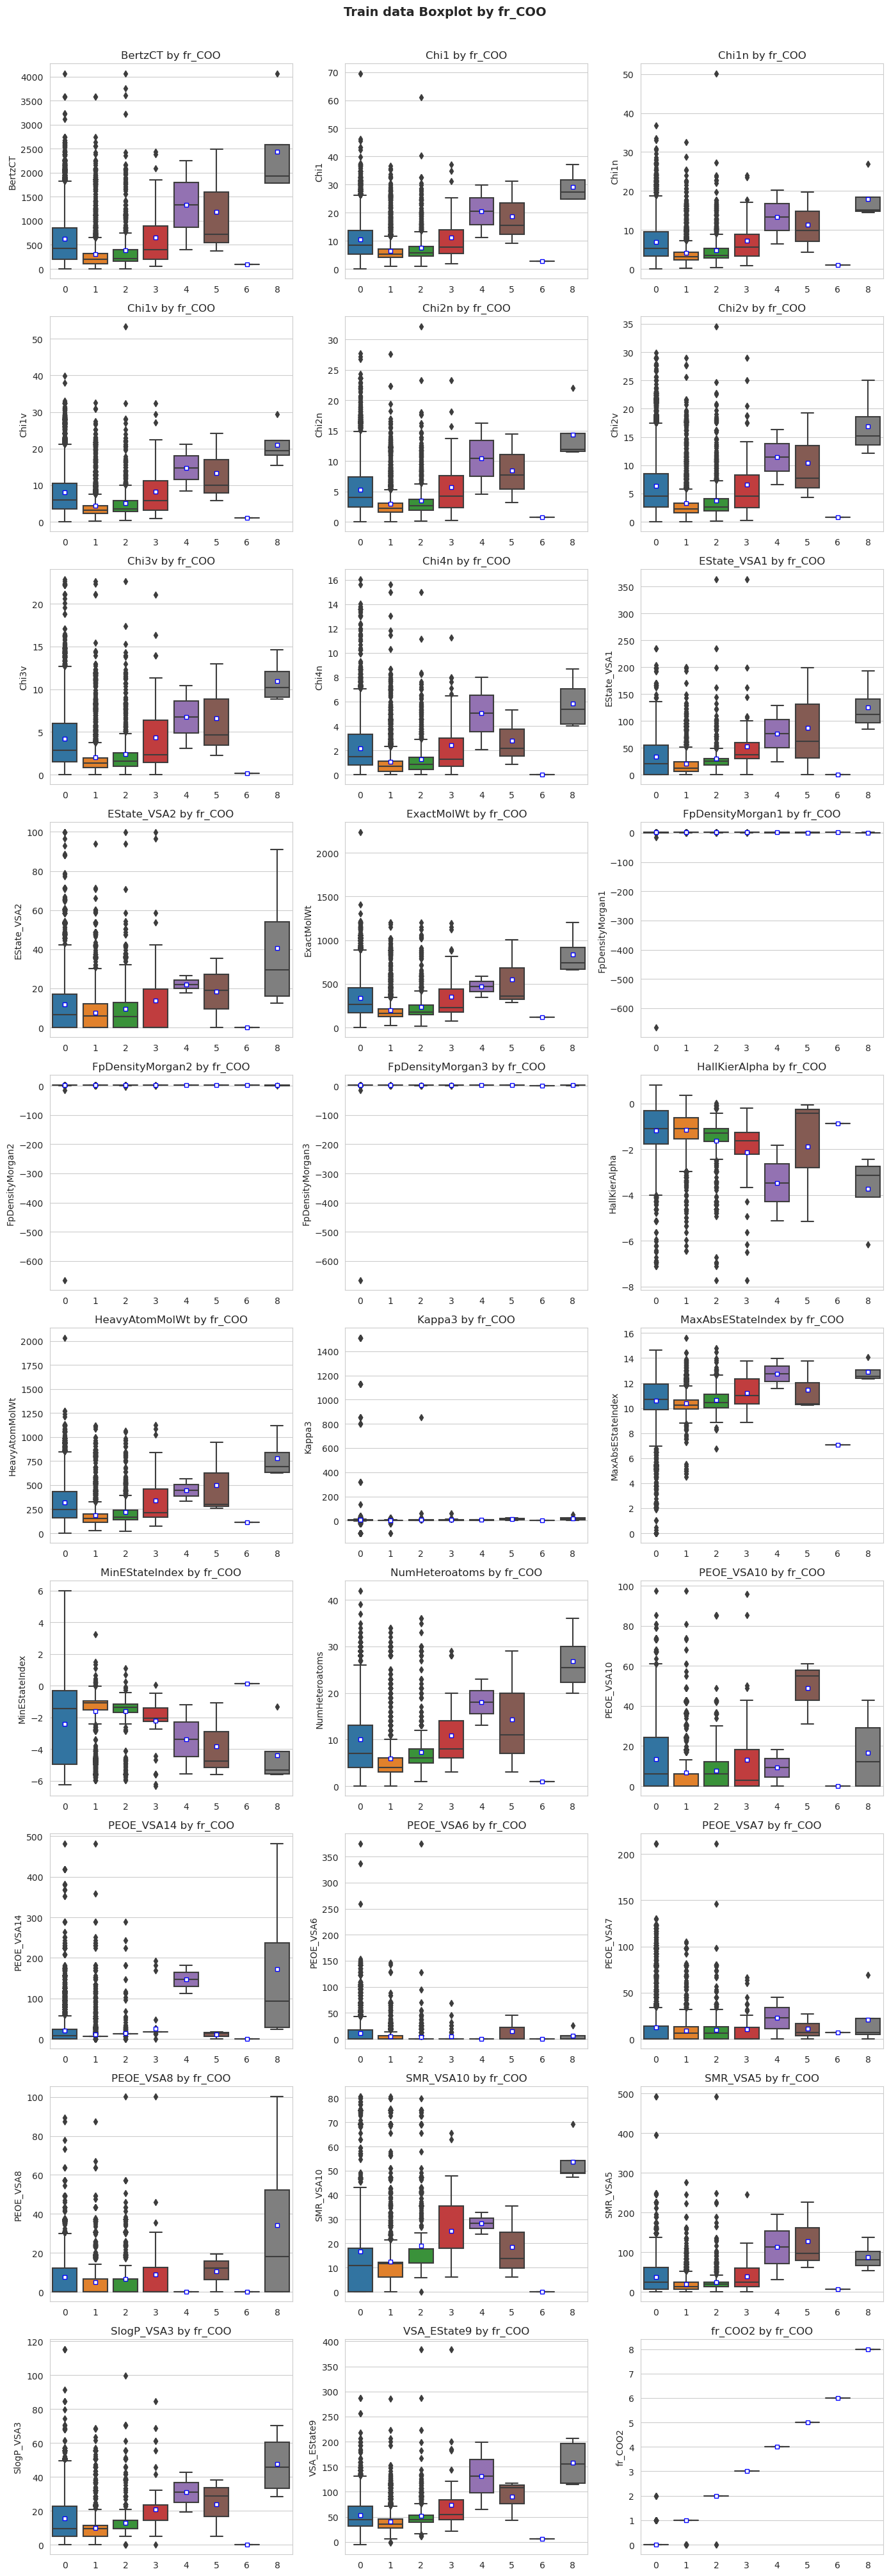

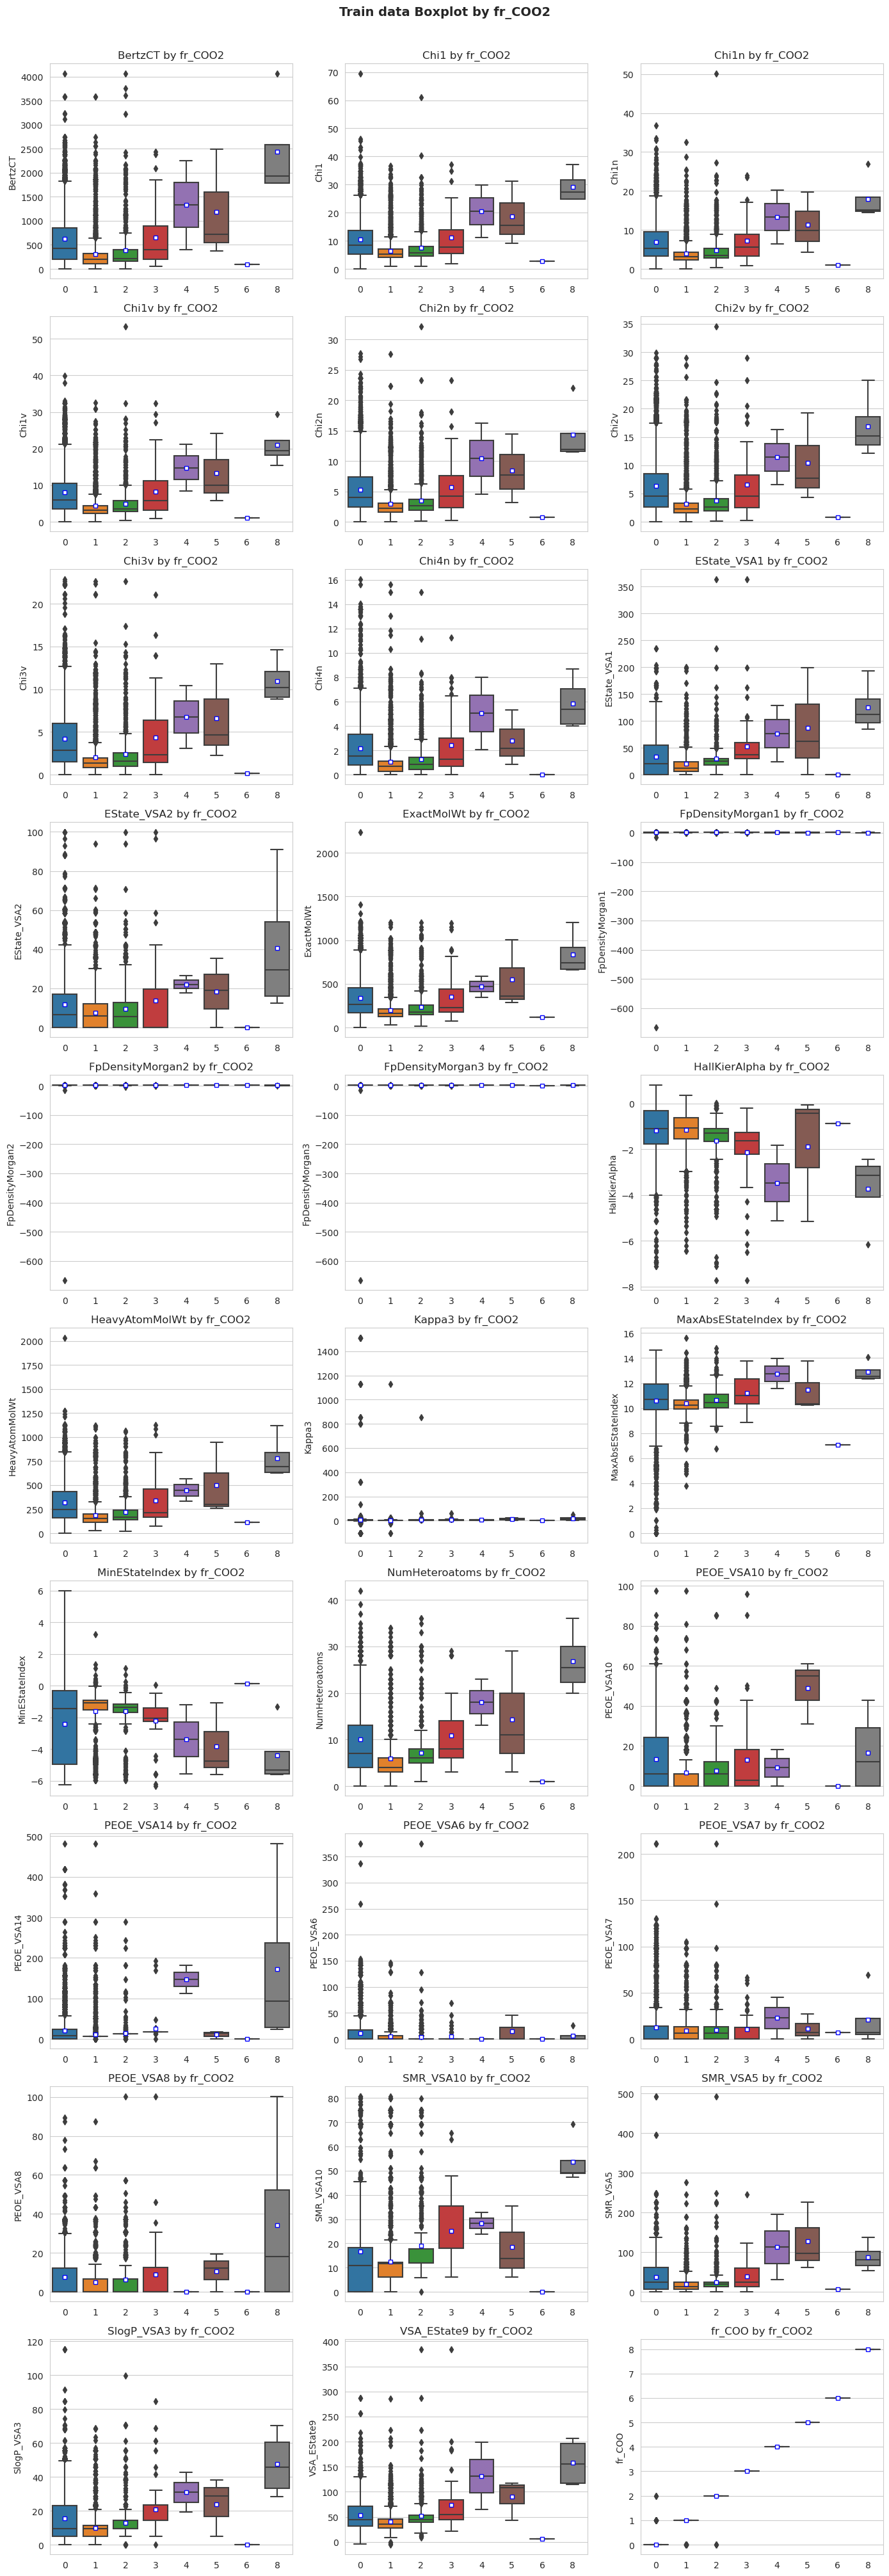

In [114]:
def plot_boxplot(df, hue, drop_cols=[], n_cols=3, title=''):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.boxplot(data=df, x=hue, y=var_name, ax=ax, showmeans=True, 
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name} by {hue}')
        ax.set_xlabel('')

    fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=14, y=1.005)
    plt.tight_layout()
    plt.show()
    
plot_boxplot(train_dataset[num_cols+target_cols], hue=target_cols[0], n_cols=4, title='Train data')
plot_boxplot(train_dataset[num_cols+target_cols], hue=target_cols[1], n_cols=4, title='Train data')
plot_boxplot(train_dataset[num_cols], hue='fr_COO', n_cols=3, title='Train data')
plot_boxplot(train_dataset[num_cols], hue='fr_COO2', n_cols=3, title='Train data')

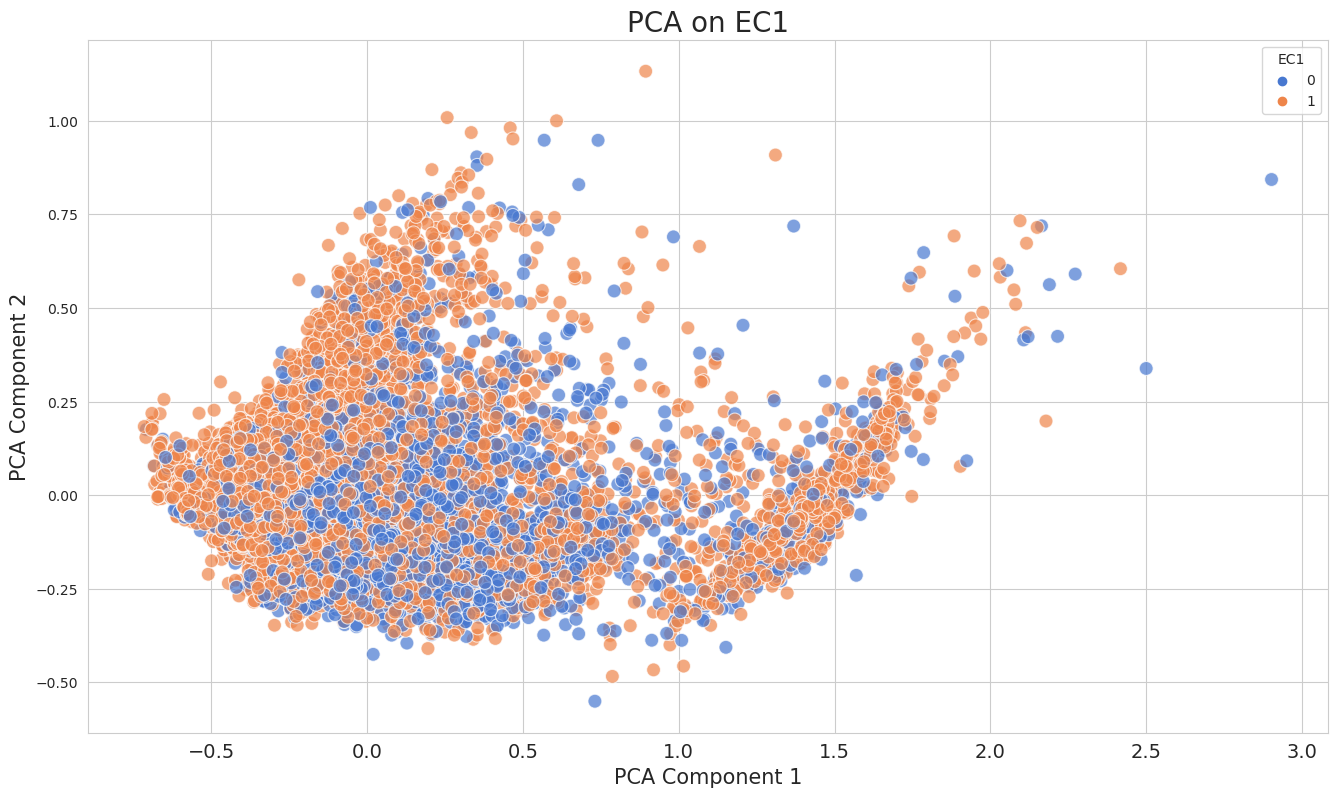

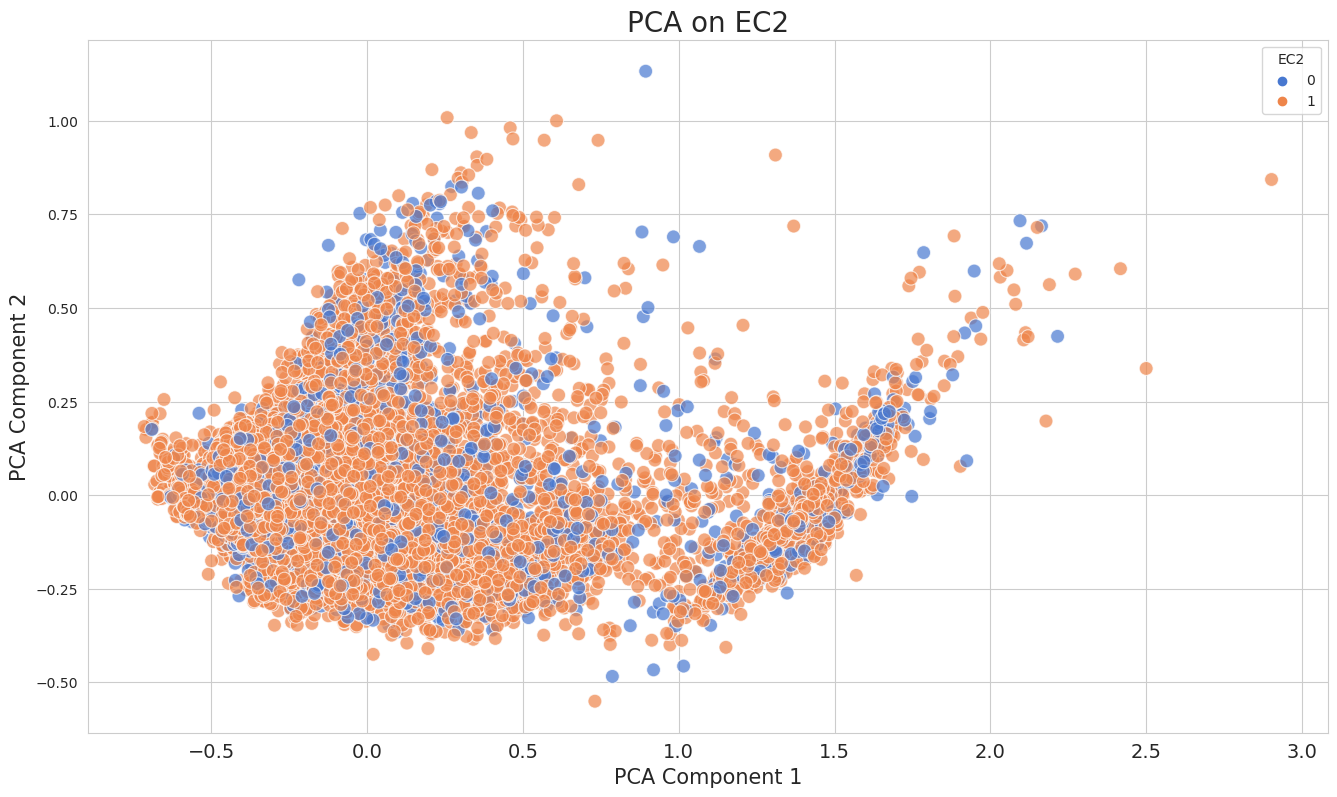

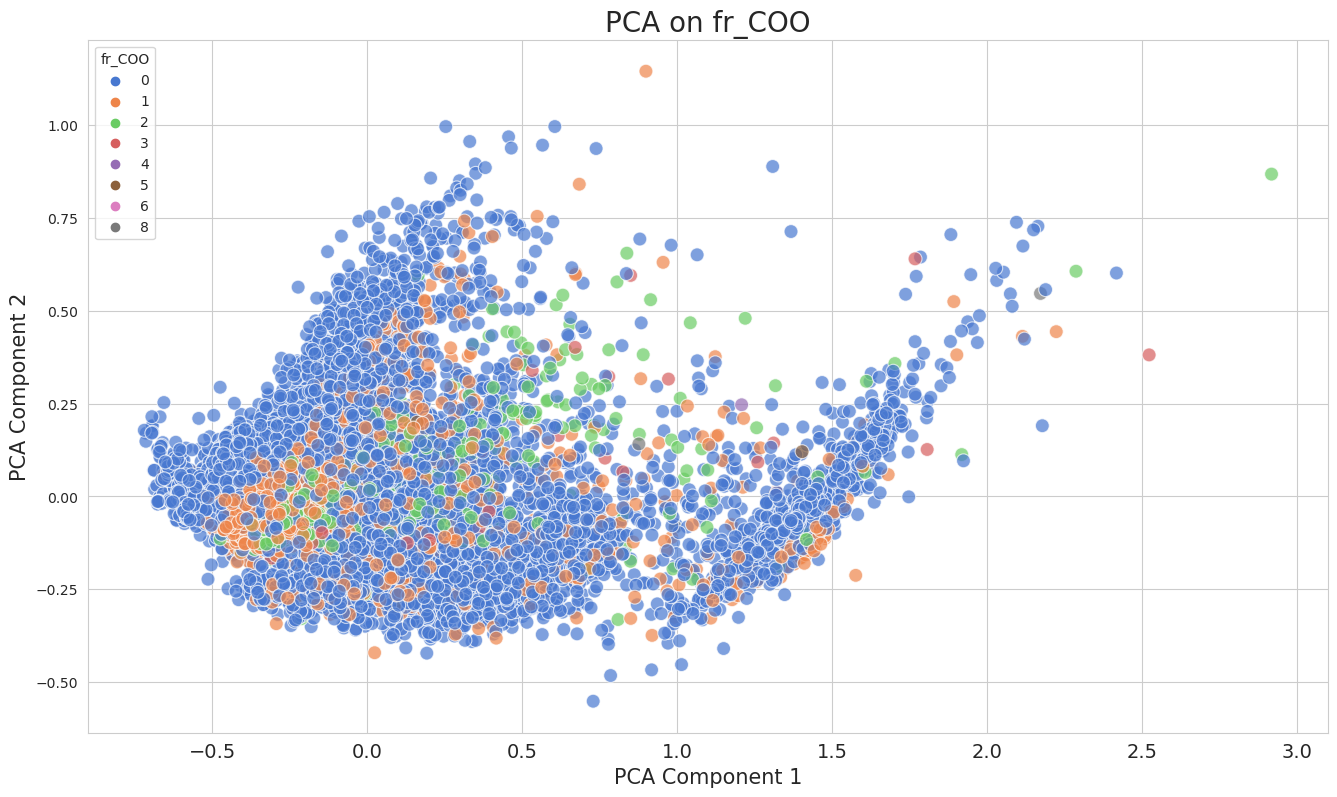

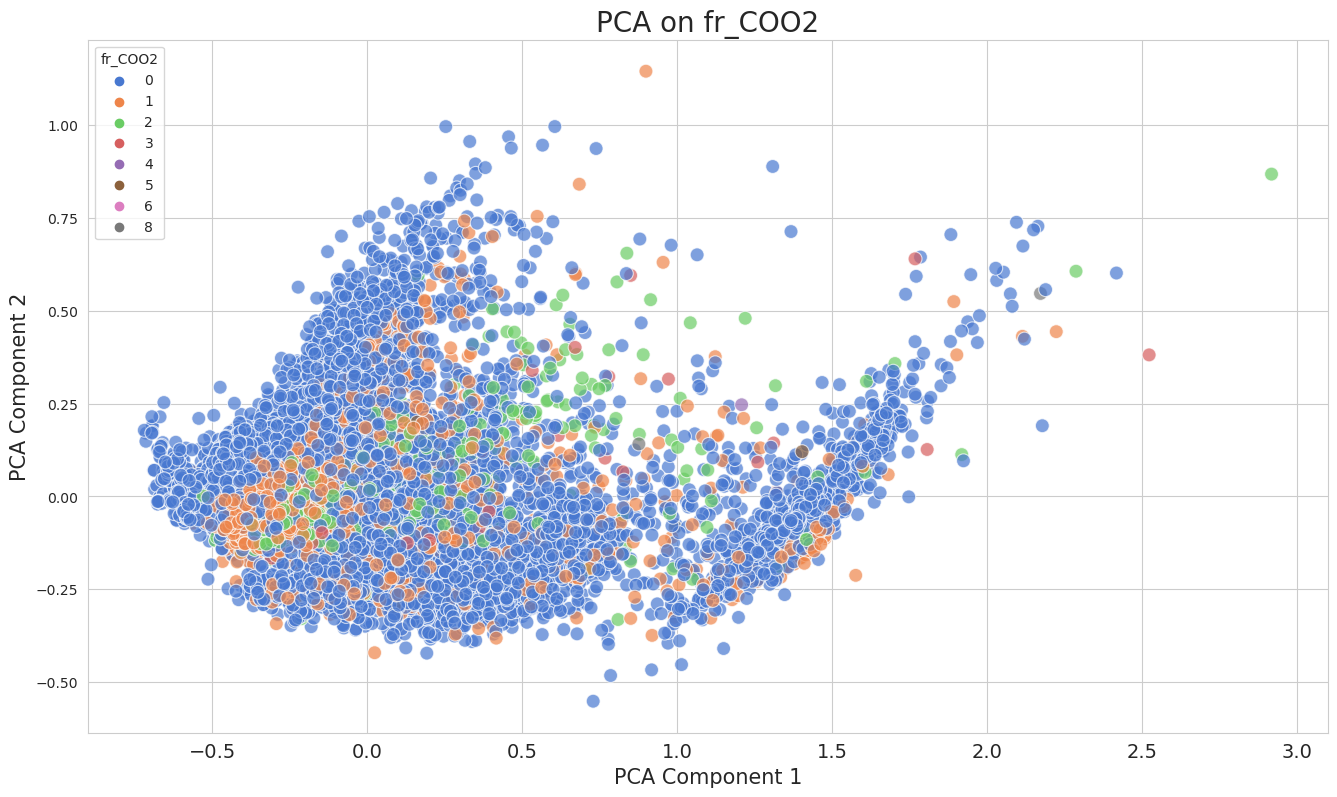

In [115]:
class Decomp:
    def __init__(self, n_components, method="pca", scaler_method='standard'):
        self.n_components = n_components
        self.method = method
        self.scaler_method = scaler_method
        
    def dimension_reduction(self, df):
            
        X_reduced = self.dimension_method(df)
        df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        return df_comp
    
    def dimension_method(self, df):
        
        X = self.scaler(df)
        if self.method == "pca":
            pca = PCA(n_components=self.n_components, random_state=0)
            X_reduced = pca.fit_transform(X)
            self.comp = pca
        elif self.method == "nmf":
            nmf = NMF(n_components=self.n_components, random_state=0)
            X_reduced = nmf.fit_transform(X)
        elif self.method == "umap":
            comp = UMAP(n_components=self.n_components, random_state=0)
            X_reduced = comp.fit_transform(X)
        elif self.method == "ica":
            comp = FastICA(n_components=self.n_components, whiten='unit-variance', random_state=0)
            X_reduced = comp.fit_transform(X)
        else:
            raise ValueError(f"Invalid method name: {method}")
        
        return X_reduced
    
    def scaler(self, df):
        
        _df = df.copy()
            
        if self.scaler_method == "standard":
            return StandardScaler().fit_transform(_df)
        elif self.scaler_method == "minmax":
            return MinMaxScaler().fit_transform(_df)
        elif self.scaler_method == None:
            return _df.values
        else:
            raise ValueError(f"Invalid scaler_method name")
        
    def get_columns(self):
        return [f'{self.method.upper()}_{_}' for _ in range(self.n_components)]
    
    def get_explained_variance_ratio(self):
        return np.sum(self.comp.explained_variance_ratio_)
    
    def transform(self, df):
        X = self.scaler(df)
        X_reduced = self.comp.transform(X)
        df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        
        return df_comp
    
    def decomp_plot(self, tmp, label, hue='genre'):
        plt.figure(figsize = (16, 9))
        sns.scatterplot(x = f"{label}_0", y = f"{label}_1", data=tmp, hue=hue, alpha=0.7, s=100, palette='muted');

        plt.title(f'{label} on {hue}', fontsize = 20)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 10);
        plt.xlabel(f"{label} Component 1", fontsize = 15)
        plt.ylabel(f"{label} Component 2", fontsize = 15)
    
    
data = train_dataset[num_cols].copy()
method = 'pca'
for target_col in target_cols:
    decomp = Decomp(n_components=2, method=method, scaler_method='minmax')
    decomp_feature = decomp.dimension_reduction(data)
    decomp_feature = pd.concat([train_dataset[target_col], decomp_feature], axis=1)
    decomp.decomp_plot(decomp_feature, method.upper(), target_col)
    
data = train_dataset[[_ for _ in num_cols if _ not in ['fr_COO', 'fr_COO2']]].copy()
method = 'pca'
for target_col in ['fr_COO', 'fr_COO2']:
    decomp = Decomp(n_components=2, method=method, scaler_method='minmax')
    decomp_feature = decomp.dimension_reduction(data)
    decomp_feature = pd.concat([train_dataset[target_col], decomp_feature], axis=1)
    decomp.decomp_plot(decomp_feature, method.upper(), target_col) 

In [116]:
def create_features(df):
    
    new_features = {
        'BertzCT_MaxAbsEStateIndex_Ratio': df['BertzCT'] / (df['MaxAbsEStateIndex'] + 1e-12),
        'BertzCT_ExactMolWt_Product': df['BertzCT'] * df['ExactMolWt'],
        'NumHeteroatoms_FpDensityMorgan1_Ratio': df['NumHeteroatoms'] / (df['FpDensityMorgan1'] + 1e-12),
        'VSA_EState9_EState_VSA1_Ratio': df['VSA_EState9'] / (df['EState_VSA1'] + 1e-12),
        'PEOE_VSA10_SMR_VSA5_Ratio': df['PEOE_VSA10'] / (df['SMR_VSA5'] + 1e-12),
        'Chi1v_ExactMolWt_Product': df['Chi1v'] * df['ExactMolWt'],
        'Chi2v_ExactMolWt_Product': df['Chi2v'] * df['ExactMolWt'],
        'Chi3v_ExactMolWt_Product': df['Chi3v'] * df['ExactMolWt'],
        'EState_VSA1_NumHeteroatoms_Product': df['EState_VSA1'] * df['NumHeteroatoms'],
        'PEOE_VSA10_Chi1_Ratio': df['PEOE_VSA10'] / (df['Chi1'] + 1e-12),
        'MaxAbsEStateIndex_NumHeteroatoms_Ratio': df['MaxAbsEStateIndex'] / (df['NumHeteroatoms'] + 1e-12),
        'BertzCT_Chi1_Ratio': df['BertzCT'] / (df['Chi1'] + 1e-12),
    }
    
    df = df.assign(**new_features)
    new_cols = list(new_features.keys())
    
    return df, new_cols

In [117]:

def add_decomp_features(X_train, X_test, n_components=5):    
    
    # Select the columns
    pca_features = X_train.select_dtypes(include=['float64']).columns.tolist()
    n_components = len(decomp_features) if n_components == 'all' else n_components

    # Create the pipeline
    pipeline = make_pipeline(MinMaxScaler(), NMF(n_components=n_components))
    
    # Perform
    pipeline.fit(X_train[decomp_features])

    # Create column names
    pca_columns = [f'NMF_{i}' for i in range(n_components)]

    # Add PCA features to the dataframe
    X_train[pca_columns] = pipeline.transform(X_train[pca_features])
    X_test[pca_columns] = pipeline.transform(X_test[pca_features])

    return X_train, X_test

class MyCategoryEncoders():
    
    def __init__(self, cat_cols, encode='label'):
        self.cat_cols = cat_cols
        self.encode = encode
        
    def cat_encoder(self, X_train, X_test):
        if self.encode == 'label':
            ## Label Encoder
            encoder = OrdinalEncoder(cols=self.cat_cols)
            train_encoder = encoder.fit_transform(X_train[self.cat_cols]).astype(int)
            test_encoder = encoder.transform(X_test[self.cat_cols]).astype(int)
            X_train[self.cat_cols] = train_encoder[self.cat_cols]
            X_test[self.cat_cols] = test_encoder[self.cat_cols]
            encoder_cols = self.cat_cols
        elif self.encode == 'count':
            ## Count Encoder
            encoder = CountEncoder(cols=self.cat_cols)
            train_encoder = encoder.fit_transform(X_train[self.cat_cols]).astype(int).add_suffix('_count')
            test_encoder = encoder.transform(X_test[self.cat_cols]).astype(int).add_suffix('_count')
            X_train = pd.concat([X_train, train_encoder], axis=1)
            X_test = pd.concat([X_test, test_encoder], axis=1)
            encoder_cols = list(train_encoder.columns)
        else:
            ## OneHot Encoder
            encoder = OneHotEncoder(handle_unknown='ignore')
            train_encoder = encoder.fit_transform(X_train[self.cat_cols]).astype(int)
            test_encoder = encoder.transform(X_test[self.cat_cols]).astype(int)
            X_train = pd.concat([X_train, train_encoder], axis=1)
            X_test = pd.concat([X_test, test_encoder], axis=1)
            X_train.drop(self.cat_cols, axis=1, inplace=True)
            X_test.drop(self.cat_cols, axis=1, inplace=True)
            encoder_cols = list(train_encoder.columns)

        return X_train, X_test, encoder_cols

class AggFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.group_col_name = ''
        for col in group_col:
            self.group_col_name += col
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.agg_df = None
        self.medians = None
        
    def fit(self, X, y=None):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        
        self.agg_df = X.groupby(group_col)[agg_col].agg(agg_func)
        self.agg_df.columns = [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]
        self.medians = X[agg_col].median()
        
        return self
    
    def transform(self, X):
        group_col = self.group_col
        agg_col = self.agg_col
        agg_func = self.agg_func
        agg_df = self.agg_df
        medians = self.medians
        
        X_merged = pd.merge(X, agg_df, left_on=group_col, right_index=True, how='left')
        X_merged.fillna(medians, inplace=True)
        X_agg = X_merged.loc[:, [f'{self.group_col_name}_{agg}_{_agg_col}' for _agg_col in agg_col for agg in agg_func]]
        
        return X_agg
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_agg = self.transform(X)
        return X_agg

In [118]:
y_trains = []
X_trains = []
X_tests = []

# Define Categorical Features
cat_cols = ['fr_COO'] # 'fr_COO2'
num_cols = list(set(num_cols) - set(cat_cols))

In [119]:
group_cols = [
        ['EState_VSA2'], ['HallKierAlpha'], ['NumHeteroatoms'], 
        ['PEOE_VSA10'], ['PEOE_VSA14'], ['PEOE_VSA6'], ['PEOE_VSA7'], ['PEOE_VSA8'],
        ['SMR_VSA10'], ['SMR_VSA5'], ['SlogP_VSA3'], ['fr_COO'], #['fr_COO2'],
    ]
agg_col = [
    'BertzCT',
    'Chi1', 
    'Chi1n', 
    'Chi1v', 
    'Chi2n', 
    'Chi2v', 
    'Chi3v', 
#         'Chi4n',
    'EState_VSA1', 
    'ExactMolWt', 
    'FpDensityMorgan1', 
    'FpDensityMorgan2', 
    'FpDensityMorgan3',
    'HeavyAtomMolWt', 
#         'Kappa3', 
    'MaxAbsEStateIndex', 
    'MinEStateIndex', 
    'VSA_EState9'
]

In [120]:
for target_col in target_cols:
    print(f'--{target_col}--')
    
    X_train = train_dataset.drop(binary_cols+target_cols, axis=1).reset_index(drop=True)
    y_train = train_dataset[f'{target_col}'].reset_index(drop=True).astype(int)
    X_test = test_dataset.reset_index(drop=True)
    
    # ------------------
    # Create combination Features
    # ------------------
    X_train, _ = create_features(X_train)
    X_test, _ = create_features(X_test)
    agg_train, agg_test = [], []
    for group_col in group_cols:
        agg_extractor = AggFeatureExtractor(group_col=group_col, agg_col=agg_col, agg_func=['mean', 'std'])
        agg_extractor.fit(pd.concat([X_train, X_test], axis=0))
        agg_train.append(agg_extractor.transform(X_train))
        agg_test.append(agg_extractor.transform(X_test))
    X_train = pd.concat([X_train] + agg_train, axis=1).fillna(0)
    X_test = pd.concat([X_test] + agg_test, axis=1).fillna(0)
    drop_cols = ['is_generated', 'fr_COO2']
    X_train = X_train.drop(drop_cols, axis=1) # +[drop_target_col]
    X_test = X_test.drop(drop_cols, axis=1)
    
    print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
    print(f"X_test shape :{X_test.shape}")
    print(f"X_train ->  isnull :{X_train.isnull().values.sum()}", f", isinf :{np.isinf(X_train).values.sum()}")
    print(f"X_test -> isnull :{X_test.isnull().values.sum()}", f", isinf :{np.isinf(X_train).values.sum()}")
    display(X_train.head(3))
    
    # Store Train and Test Data
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)

--EC1--
X_train shape :(14838, 426) , y_train shape :(14838,)
X_test shape :(9893, 432)
X_train ->  isnull :0 , isinf :0
X_test -> isnull :0 , isinf :0


BertzCT       Chi1     Chi1n      Chi1v     Chi2n     Chi2v     Chi3v  \
0  323.390782   9.879918  5.875576   5.875576  4.304757  4.304757  2.754513   
1  273.723798   7.259037  4.441467   5.834958  3.285046  4.485235  2.201375   
2  521.643822  10.911303  8.527859  11.050864  6.665291  9.519706  5.824822   

      Chi4n  EState_VSA1  EState_VSA2  ExactMolWt  FpDensityMorgan1  \
0  1.749203     0.000000    11.938294  222.068080          1.181818   
1  1.289775    45.135471     0.000000  260.029719          1.346154   
2  1.770579    15.645394     6.606882  382.131027          1.085714   

   FpDensityMorgan2  FpDensityMorgan3  HallKierAlpha  HeavyAtomMolWt  \
0          1.727273          2.363636          -0.24         212.163   
1          2.076923          2.769231          -0.09         247.031   
2          1.742857          2.400000          -0.78         354.106   

      Kappa3  MaxAbsEStateIndex  MinEStateIndex  NumHeteroatoms  PEOE_VSA10  \
0   8.170000          11.922504        0.171585               4    0.000000   
1   3.201491          10.932338       -4.830450              10   24.415866   
2  15.033890          11.238048       -5.066255               9    0.000000   

   PEOE_VSA14  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  SMR_VSA10   SMR_VSA5  \
0   91.536492        0.0   0.000000        0.0  17.744066   0.000000   
1    7.822697        0.0   0.000000        0.0   7.822697  30.705892   
2   15.645394        0.0  53.378235        0.0  15.645394  73.143616   

   SlogP_VSA3  VSA_EState9  fr_COO  BertzCT_MaxAbsEStateIndex_Ratio  \
0    4.794537    35.527357       0                        27.124401   
1   13.825658    44.707310       0                        25.037993   
2   17.964475    45.660120       0                        46.417653   

   BertzCT_ExactMolWt_Product  NumHeteroatoms_FpDensityMorgan1_Ratio  \
0                71814.769986                               3.384615   
1                71176.322090                               7.428571   
2               199336.289321                               8.289474   

   VSA_EState9_EState_VSA1_Ratio  PEOE_VSA10_SMR_VSA5_Ratio  \
0                   3.552736e+13                   0.000000   
1                   9.905139e-01                   0.795152   
2                   2.918438e+00                   0.000000   

   Chi1v_ExactMolWt_Product  Chi2v_ExactMolWt_Product  \
0               1304.777912                955.949195   
1               1517.262475               1166.294470   
2               4222.878153               3637.774976   

   Chi3v_ExactMolWt_Product  EState_VSA1_NumHeteroatoms_Product  \
0                611.689443                            0.000000   
1                572.422875                          451.354714   
2               2225.845264                          140.808548   

   PEOE_VSA10_Chi1_Ratio  MaxAbsEStateIndex_NumHeteroatoms_Ratio  \
0               0.000000                                2.980626   
1               3.363513                                1.093234   
2               0.000000                                1.248672   

   BertzCT_Chi1_Ratio  EState_VSA2_mean_BertzCT  EState_VSA2_std_BertzCT  \
0           32.732133                323.390782                 0.000000   
1           37.708002                329.038349               365.406520   
2           47.807658                393.507795               341.852941   

   EState_VSA2_mean_Chi1  EState_VSA2_std_Chi1  EState_VSA2_mean_Chi1n  \
0               9.879918              0.000000                5.875576   
1               6.821534              4.579100                4.185633   
2               7.806045              4.250615                5.111827   

   EState_VSA2_std_Chi1n  EState_VSA2_mean_Chi1v  EState_VSA2_std_Chi1v  \
0               0.000000                5.875576               0.000000   
1               3.048786                4.806772               3.771718   
2               3.262089                5.897715               3.762800   

   EStat

--EC2--
X_train shape :(14838, 426) , y_train shape :(14838,)
X_test shape :(9893, 432)
X_train ->  isnull :0 , isinf :0
X_test -> isnull :0 , isinf :0


BertzCT       Chi1     Chi1n      Chi1v     Chi2n     Chi2v     Chi3v  \
0  323.390782   9.879918  5.875576   5.875576  4.304757  4.304757  2.754513   
1  273.723798   7.259037  4.441467   5.834958  3.285046  4.485235  2.201375   
2  521.643822  10.911303  8.527859  11.050864  6.665291  9.519706  5.824822   

      Chi4n  EState_VSA1  EState_VSA2  ExactMolWt  FpDensityMorgan1  \
0  1.749203     0.000000    11.938294  222.068080          1.181818   
1  1.289775    45.135471     0.000000  260.029719          1.346154   
2  1.770579    15.645394     6.606882  382.131027          1.085714   

   FpDensityMorgan2  FpDensityMorgan3  HallKierAlpha  HeavyAtomMolWt  \
0          1.727273          2.363636          -0.24         212.163   
1          2.076923          2.769231          -0.09         247.031   
2          1.742857          2.400000          -0.78         354.106   

      Kappa3  MaxAbsEStateIndex  MinEStateIndex  NumHeteroatoms  PEOE_VSA10  \
0   8.170000          11.922504        0.171585               4    0.000000   
1   3.201491          10.932338       -4.830450              10   24.415866   
2  15.033890          11.238048       -5.066255               9    0.000000   

   PEOE_VSA14  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  SMR_VSA10   SMR_VSA5  \
0   91.536492        0.0   0.000000        0.0  17.744066   0.000000   
1    7.822697        0.0   0.000000        0.0   7.822697  30.705892   
2   15.645394        0.0  53.378235        0.0  15.645394  73.143616   

   SlogP_VSA3  VSA_EState9  fr_COO  BertzCT_MaxAbsEStateIndex_Ratio  \
0    4.794537    35.527357       0                        27.124401   
1   13.825658    44.707310       0                        25.037993   
2   17.964475    45.660120       0                        46.417653   

   BertzCT_ExactMolWt_Product  NumHeteroatoms_FpDensityMorgan1_Ratio  \
0                71814.769986                               3.384615   
1                71176.322090                               7.428571   
2               199336.289321                               8.289474   

   VSA_EState9_EState_VSA1_Ratio  PEOE_VSA10_SMR_VSA5_Ratio  \
0                   3.552736e+13                   0.000000   
1                   9.905139e-01                   0.795152   
2                   2.918438e+00                   0.000000   

   Chi1v_ExactMolWt_Product  Chi2v_ExactMolWt_Product  \
0               1304.777912                955.949195   
1               1517.262475               1166.294470   
2               4222.878153               3637.774976   

   Chi3v_ExactMolWt_Product  EState_VSA1_NumHeteroatoms_Product  \
0                611.689443                            0.000000   
1                572.422875                          451.354714   
2               2225.845264                          140.808548   

   PEOE_VSA10_Chi1_Ratio  MaxAbsEStateIndex_NumHeteroatoms_Ratio  \
0               0.000000                                2.980626   
1               3.363513                                1.093234   
2               0.000000                                1.248672   

   BertzCT_Chi1_Ratio  EState_VSA2_mean_BertzCT  EState_VSA2_std_BertzCT  \
0           32.732133                323.390782                 0.000000   
1           37.708002                329.038349               365.406520   
2           47.807658                393.507795               341.852941   

   EState_VSA2_mean_Chi1  EState_VSA2_std_Chi1  EState_VSA2_mean_Chi1n  \
0               9.879918              0.000000                5.875576   
1               6.821534              4.579100                4.185633   
2               7.806045              4.250615                5.111827   

   EState_VSA2_std_Chi1n  EState_VSA2_mean_Chi1v  EState_VSA2_std_Chi1v  \
0               0.000000                5.875576               0.000000   
1               3.048786                4.806772               3.771718   
2               3.262089                5.897715               3.762800   

   EStat

In [121]:
# Settings
kfold = 'skf'
n_splits = 10 # 10
n_reapts = 5 # 1
random_state = 42
n_estimators = 9999 # 9999
early_stopping_rounds = 200
n_trials = 1000 # 3000
verbose = False
device = 'cpu'

# Fix seed
random.seed(random_state)
random_state_list = random.sample(range(9999), n_reapts)
# random_state_list = [42]
# n_reapts = len(random_state_list)

# metrics
def auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)
metric = auc
metric_name = metric.__name__.upper()

# To calculate runtime
def sec_to_minsec(t):
    min_ = int(t / 60)
    sec = int(t - min_*60)
    return min_, sec


In [122]:
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics

In [123]:
metrics.roc_auc_score(y_train , y_train)

1.0

In [124]:
def objective(trial):

#     classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest"])
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    classifier_obj = RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators
    )
    
    classifier_obj.fit(X_train,y_train)
        # Step 3: Scoring method:
    y_pred = classifier_obj.predict(X_train)
    score = metrics.roc_auc_score(y_train,y_pred)
#         intermediate_value = 1.0 - clf.score(valid_x, valid_y)
#         trial.report(score, step)

#         # Handle pruning based on the intermediate value.
#         if trial.should_prune():
#             raise optuna.TrialPruned()
#     accuracy = score.mean()
    return score

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-07-02 13:13:17,324] A new study created in memory with name: no-name-ce85546d-9739-49eb-b9ce-a0fc41e7fe3e
[I 2023-07-02 13:13:25,944] Trial 0 finished with value: 0.5 and parameters: {'rf_n_estimators': 406, 'rf_max_depth': 2}. Best is trial 0 with value: 0.5.
[I 2023-07-02 13:13:53,869] Trial 1 finished with value: 0.5 and parameters: {'rf_n_estimators': 951, 'rf_max_depth': 3}. Best is trial 0 with value: 0.5.
[I 2023-07-02 13:15:01,515] Trial 2 finished with value: 0.554140127388535 and parameters: {'rf_n_estimators': 619, 'rf_max_depth': 12}. Best is trial 2 with value: 0.554140127388535.
[I 2023-07-02 13:15:15,124] Trial 3 finished with value: 0.5 and parameters: {'rf_n_estimators': 358, 'rf_max_depth': 4}. Best is trial 2 with value: 0.554140127388535.
[I 2023-07-02 13:15:34,685] Trial 4 finished with value: 0.5 and parameters: {'rf_n_estimators': 927, 'rf_max_depth': 2}. Best is trial 2 with value: 0.554140127388535.
[I 2023-07-02 13:15:36,800] Trial 5 finished with valu

In [125]:
study.best_trial

FrozenTrial(number=48, state=TrialState.COMPLETE, values=[0.9854173650687227], datetime_start=datetime.datetime(2023, 7, 2, 14, 35, 51, 915708), datetime_complete=datetime.datetime(2023, 7, 2, 14, 39, 11, 534131), params={'rf_n_estimators': 978, 'rf_max_depth': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'rf_max_depth': IntDistribution(high=32, log=True, low=2, step=1)}, trial_id=48, value=None)

In [126]:
study.best_params

{'rf_n_estimators': 978, 'rf_max_depth': 32}

In [133]:
set(X_test.columns) - set(X_train.columns )

{'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'}

In [135]:
set(X_train.columns) - set(X_test.columns )

set()

In [134]:
clf = RandomForestClassifier(
        max_depth=32, n_estimators=978)
clf.fit(X_train , y_train)
# ### y_pred = clf.predict(X_test)

In [136]:
y_pred = clf.predict(X_test[list(X_train.columns)])

In [137]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [138]:
pred_df = pd.DataFrame(columns = ['EC1', 'EC2'])
pred_df['EC2'] = y_pred

In [139]:
def objective(trial):

#     classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest"])
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    classifier_obj = RandomForestClassifier(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators
    )
    
    classifier_obj.fit(X_trains[0],y_trains[0])
        # Step 3: Scoring method:
    y_pred = classifier_obj.predict(X_trains[0])
    score = metrics.roc_auc_score(y_trains[0],y_pred)
#         intermediate_value = 1.0 - clf.score(valid_x, valid_y)
#         trial.report(score, step)

#         # Handle pruning based on the intermediate value.
#         if trial.should_prune():
#             raise optuna.TrialPruned()
#     accuracy = score.mean()
    return score

# Step 4: Running it
study_2 = optuna.create_study(direction="maximize")
study_2.optimize(objective, n_trials=50)

[I 2023-07-02 16:58:42,975] A new study created in memory with name: no-name-1742b2be-04f3-4475-9917-a0fb168320af
[I 2023-07-02 16:59:00,137] Trial 0 finished with value: 0.6321628966205111 and parameters: {'rf_n_estimators': 587, 'rf_max_depth': 3}. Best is trial 0 with value: 0.6321628966205111.
[I 2023-07-02 17:00:14,599] Trial 1 finished with value: 0.9310962477511155 and parameters: {'rf_n_estimators': 474, 'rf_max_depth': 20}. Best is trial 1 with value: 0.9310962477511155.
[I 2023-07-02 17:01:13,208] Trial 2 finished with value: 0.6969791043113889 and parameters: {'rf_n_estimators': 797, 'rf_max_depth': 8}. Best is trial 1 with value: 0.9310962477511155.
[I 2023-07-02 17:01:29,592] Trial 3 finished with value: 0.6555627390655286 and parameters: {'rf_n_estimators': 293, 'rf_max_depth': 6}. Best is trial 1 with value: 0.9310962477511155.
[I 2023-07-02 17:01:52,582] Trial 4 finished with value: 0.6321663359704413 and parameters: {'rf_n_estimators': 784, 'rf_max_depth': 3}. Best is 

In [140]:
study_2.best_params

{'rf_n_estimators': 303, 'rf_max_depth': 32}

In [141]:
clf = RandomForestClassifier(
        max_depth=32, n_estimators=202)
clf.fit(X_trains[0] , y_trains[0])
# ### y_pred = clf.predict(X_test)

RandomForestClassifier(max_depth=32, n_estimators=202)

In [142]:
y_pred = clf.predict(X_tests[0][list(X_trains[0].columns)])

In [143]:
pred_df['EC1'] = y_pred

In [145]:
pred_df.value_counts()

EC1  EC2
1    1      7815
0    1      1994
1    0        79
0    0         5
dtype: int64

In [152]:
pred_df.shape

(9893, 2)

In [151]:
test_dataset.index

Int64Index([14838, 14839, 14840, 14841, 14842, 14843, 14844, 14845, 14846,
            14847,
            ...
            24721, 24722, 24723, 24724, 24725, 24726, 24727, 24728, 24729,
            24730],
           dtype='int64', name='id', length=9893)

In [153]:
pred_df['id'] = test_dataset.index

In [154]:
 sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))

In [156]:
pred_df

EC1  EC2     id
0       1    1  14838
1       1    1  14839
2       1    1  14840
3       1    1  14841
4       1    1  14842
...   ...  ...    ...
9888    1    1  24726
9889    1    1  24727
9890    0    1  24728
9891    1    1  24729
9892    0    1  24730

[9893 rows x 3 columns]

In [158]:
for each in target_cols : 
    sub[each] = pred_df[each].values

In [159]:
sub.to_csv('submission.csv', index=False)